#### Terminology point:

This project relies quite a bit on how names are categorized by the Social Security Administration. Each birth is registered as either male or female, and throughout the text, these terms refer to that assigned sex.

In [1]:
#It's been talked about so often times that it's hard to find an 
#original source, but the idea of "unique but familiar" is all
#over in marketing. Probably the most famous version is "Most
#Advanced Yet Acceptable", coined by Raymond Loewy. Basically,
#people like things that are new, but fit somewhere they know.

#For this project, my goal is to help users find names that "fit".
#If a name 1) feels familiar, and 2) tells you immediately that 
#the named person is from a specific time period or age range, 
#that's what I'm going for. Familiar, but unique enough to tell 
#you useful information about the person's age or the year. 

#Say you want to market something to people around 65. Do you
#want to pick "Jacob" as a name in an ad? Probably not. The 
#vast majority of people named "Jacob" are under 40. What if
#you wanted to have a believable name for someone 20-30 in a
#period piece set in 1990? You really don't want "Cayden", 
#that much you probably know, but how do we figure out who

#"Most Advanced Yet Acceptable"
#https://www.theatlantic.com/magazine/archive/2017/01/what-makes-things-cool/508772/

In [2]:
%config Completer.use_jedi = False
#Autocomplete has been finicky, switching versions. 

In [3]:
import numpy as np
import pandas as pd
import csv
import os
import time

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
import colorsys
from wordcloud import WordCloud

from plotly.subplots import make_subplots
import plotly.graph_objects as go

import datetime as dt
import pickle

import requests
from bs4 import BeautifulSoup
from requests_futures.sessions import FuturesSession

pd.set_option('display.max_rows',150)


In [4]:
#Set figure options:

#Yes, I want this as a universal default across all notebooks.
matplotlib.rcParams['font.sans-serif'] = ['Helvetica']

plt.rc('font', size=12)          # controls default text sizes
plt.rc('axes', titlesize=16)     # fontsize of the axes title
plt.rc('axes', labelsize=14)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)    # fontsize of the tick labels
# plt.rc('legend', fontsize=12)    # legend fontsize
# plt.rc('figure', titlesize=10)  # fontsize of the figure title

In [5]:
#Load in preprocessed data. The "namelife_S_full" files are by
#far the largest, at 3-4 gigs.

alive_F = pd.read_pickle('/Users/chmullens/Documents/python_work/Actuarial_tables/life_F_df.pkl')
alive_M = pd.read_pickle('/Users/chmullens/Documents/python_work/Actuarial_tables/life_M_df.pkl')
alive_F_p = pd.read_pickle('/Users/chmullens/Documents/python_work/Actuarial_tables/life_F_p_df.pkl')
alive_M_p = pd.read_pickle('/Users/chmullens/Documents/python_work/Actuarial_tables/life_M_p_df.pkl')

#alive_M_t = alive_M.values.astype('float64').T
#alive_F_t = alive_F.values.astype('float64').T

#MOVING ALL PREPROCESSING BACK INTO THIS FILE. The file generation taken
#back from the "Names_preprocessing" script generates the following files:

# totalnames_table = pd.read_pickle('Total_soc_cards.pkl')
# names_df_trim = pd.read_pickle('names_df_trim.pkl')

# namelife_F_full = np.load('namelife_F_full.npy')
# namelife_F_base = np.load('namelife_F_base.npy')
# namelife_F_name = pd.read_pickle('namelife_F_name.pkl')
# namebirth_F = np.load('namebirth_F.npy')
# namelife_M_full = np.load('namelife_M_full.npy')
# namelife_M_base = np.load('namelife_M_base.npy')
# namelife_M_name = pd.read_pickle('namelife_M_name.pkl')
# namebirth_M = np.load('namebirth_M.npy')

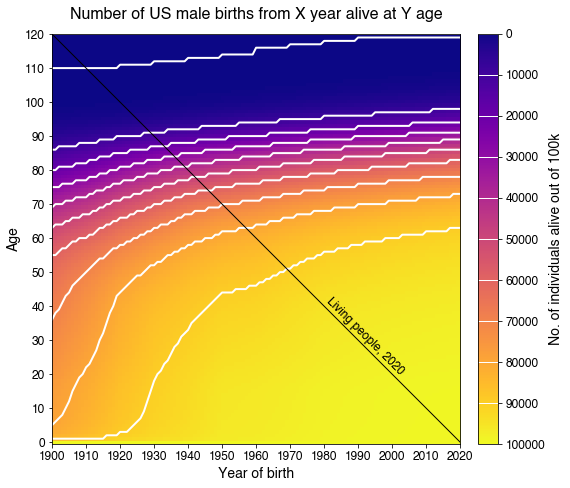

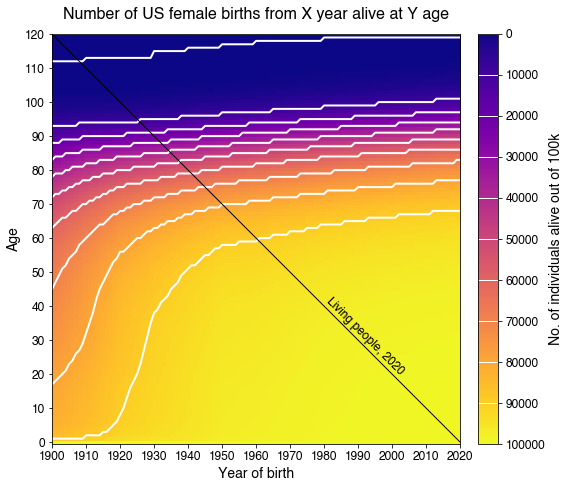

In [6]:
#OPTIONAL DATA VISUALIZATION

#In general:
showplot = False

#This specific plot I am defaulting to true:
if True:
    
    alive_M_t = alive_M.values.astype('float64').T
    alive_F_t = alive_F.values.astype('float64').T
    
    #Exploratory comparison:
    fig = plt.figure(figsize=[8,8])
    ax = plt.subplot(111, aspect='equal')
    cax = ax.imshow(alive_M_t, cmap='plasma')
    plt.title('Number of US male births from X year alive at Y age', pad=15)
    plt.ylabel('Age')
    plt.xlabel('Year of birth')

    #Get contours:
    contours_alive = np.zeros([alive_M_t.shape[1], 11])
    alive_num = []
    for n in range(10):

        #Note: Below method for finding first index at which the comparison
        #is true is not necessarily the best, it may cause spotty outputs for
        #unsorted data for example, but allows multidimensional comparison 
        #natively with use of the 'axis' variable. Where, nonzero, and
        #searchsorted use a 1D array and would have to be reindexed. Would be
        #good flatten/rebuild matrix practice at some point in the future.
        #
        #Good discussion here: 
        #https://stackoverflow.com/questions/16243955/numpy-first-occurrence-of-value-greater-than-existing-value

        #Find first index at which fewer than X people are alive:
        contours_alive[:,n] = np.argmax(alive_M_t < (100000 - n*10000), axis=0)

        alive_num.append(100000 - n*10000)

    contours_alive[:,10] = np.argmax(alive_M_t < 1, axis=0)
    contours_alive[contours_alive[:,10]==0, 10] = np.max(contours_alive[:,10])
    alive_num.append(0)

    plt.plot(contours_alive[:,1:], color=[1,1,1], linewidth=2)

    ax.plot([120,0],[0,120],'k',linewidth=1)
    txtemp = ax.text(80,20, 'Living people, 2020', size=12, rotation=-45)

    plt.ylim([-0.5,119.5])
    plt.xlim([.5,120])

    ax.set_xticks(np.arange(0,121,10))
    ax.set_xticklabels((np.arange(0,121,10) + 1900).astype('str'))
    ax.set_yticks(np.arange(0,121,10))


    cbar = fig.colorbar(cax, 
                        ticks=alive_num, fraction=0.046, pad=0.04,
                        label='No. of individuals alive out of 100k',)
    cbar.ax.set_yticklabels(alive_num)  # vertically oriented colorbar
    cbar_lims = cbar.ax.get_xlim()
    cbar.ax.invert_yaxis()
    cbar.ax.hlines(alive_num, cbar_lims[0], cbar_lims[1], colors='w', linewidth=1)
    fig.set_facecolor('white')

    plt.show()


    #Redo for F:
    fig = plt.figure(figsize=[8,8])
    ax = plt.subplot(111, aspect='equal')
    cax = ax.imshow(alive_F_t, cmap='plasma')
    plt.title('Number of US female births from X year alive at Y age', pad=15)
    plt.ylabel('Age')
    plt.xlabel('Year of birth')

    #Get contours:
    contours_alive = np.zeros([alive_F_t.shape[1], 11])
    alive_num = []
    for n in range(10):

        #Note: Below method for finding first index at which the comparison
        #is true is not necessarily the best, it may cause spotty outputs for
        #unsorted data for example, but allows multidimensional comparison 
        #natively with use of the 'axis' variable. Where, nonzero, and
        #searchsorted use a 1D array and would have to be reindexed. Would be
        #good flatten/rebuild matrix practice at some point in the future.
        #
        #Good discussion here: 
        #https://stackoverflow.com/questions/16243955/numpy-first-occurrence-of-value-greater-than-existing-value

        #Find first index at which fewer than X people are alive:
        contours_alive[:,n] = np.argmax(alive_F_t < (100000 - n*10000), axis=0)

        alive_num.append(100000 - n*10000)

    contours_alive[:,10] = np.argmax(alive_F_t < 1, axis=0)
    contours_alive[contours_alive[:,10]==0,10] = np.max(contours_alive[:,10])
    alive_num.append(0)

    plt.plot(contours_alive[:,1:], color=[1,1,1], linewidth=2)

    ax.plot([120,0],[0,120],'k',linewidth=1)
    txtemp = ax.text(80,20, 'Living people, 2020', size=12, rotation=-45)

    plt.ylim([-0.5,119.5])
    plt.xlim([.5,120])

    ax.set_xticks(np.arange(0,121,10))
    ax.set_xticklabels((np.arange(0,121,10) + 1900).astype('str'))
    ax.set_yticks(np.arange(0,121,10))


    cbar = fig.colorbar(cax, 
                        ticks=alive_num, fraction=0.046, pad=0.04,
                        label='No. of individuals alive out of 100k',)
    cbar.ax.set_yticklabels(alive_num)  # vertically oriented colorbar
    cbar.ax.invert_yaxis()
    cbar_lims = cbar.ax.get_xlim()
    cbar.ax.hlines(alive_num, cbar_lims[0], cbar_lims[1], colors='w', linewidth=1)
    fig.set_facecolor('white')

    plt.show()

In [7]:
#Get the yearly total of all names (including sub-5) from Social Security 
#Admin, by year (useful for normalization)
#
#https://www.ssa.gov/oact/babynames/numberUSbirths.html

#Gets the data raw from the website and pickles it.

reload = False

if reload:
    response = requests.get('https://www.ssa.gov/oact/babynames/numberUSbirths.html')
    totalnames_table = pd.read_html(response.text, index_col='Year of birth')
    totalnames_table = totalnames_table[0]
    totalnames_table.to_pickle('Total_soc_cards.pkl')
else:
    totalnames_table = pd.read_pickle('Total_soc_cards.pkl')

In [8]:
#Load the year-of-birth data, in "yobYYYY.txt" format csv files.
#
#Data source: https://www.ssa.gov/OACT/babynames/limits.html,
#has national zip file that unpacks to the files below.

os.chdir('../Names/names_w2020')
current_dir = os.listdir()

names_temp = []
for ftemp in current_dir:
    if ftemp[-3:] == 'txt':
        dftemp = pd.read_csv(ftemp, names=['Name','Sex','Number'])
        dftemp['Year'] = int(ftemp[3:-4])
        names_temp.append(dftemp)
        
names_df = pd.concat(names_temp)
names_df.info()

os.chdir('..')
#These births will be called "nameset births" from here on out.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2020863 entries, 0 to 32029
Data columns (total 4 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   Name    object
 1   Sex     object
 2   Number  int64 
 3   Year    int64 
dtypes: int64(2), object(2)
memory usage: 77.1+ MB


In [9]:
#Reset the indexes to unduplicate them, since each stack was indexed 
#separately; keeping the old indices is handy though, so default
#'drop = false' option is kept.

#Yes, the sorting matters. It makes plotting way easier later on, and
#I could definitely use it to speed up the name structure indexing. 

names_df = names_df.reset_index().sort_values(['Name','Year'])

names_df

,index,Name,Sex,Number,Year
448147,32930,Aaban,M,5,2007
1658105,31173,Aaban,M,6,2009
622098,27952,Aaban,M,9,2010
542612,26573,Aaban,M,11,2011
342321,26563,Aaban,M,11,2012
...,...,...,...,...,...
127440,29734,Zyvon,M,7,2015
611121,16975,Zyyanna,F,6,2010
61078,31301,Zyyon,M,6,2014
628230,34084,Zzyzx,M,5,2010


In [10]:
#Above is raw, not controlled for population or births. What was 
#the total as a fraction of the year's name births? Currently only
#using the over-5-names as the core comparison. Could pull from
#the social security total above, here, in future improvements.

year_total = names_df.groupby('Year').sum()

#Join year_total w/ names_df to get what fraction of total births
#that year made up of the given name/sex pair:
names_df = pd.merge(left=names_df, right=totalnames_table, 
                    left_on='Year', right_on='Year of birth', 
                    how='left')
names_df['Fraction'] = names_df['Number']/names_df['Total']

#Not normalizing to number of male or female births, just total.
#Possible future improvement, since likelihood of registering
#appears to have had some sex bias early on. 
names_df.drop(columns=['Male','Female','Total'], inplace=True)

In [11]:
names_df.head()

,index,Name,Sex,Number,Year,Fraction
0,32930,Aaban,M,5,2007,0.000001
1,31173,Aaban,M,6,2009,0.000001
2,27952,Aaban,M,9,2010,0.000002
3,26573,Aaban,M,11,2011,0.000003
4,26563,Aaban,M,11,2012,0.000003


In [12]:
#Calculate total number of births for each name:
totalbirths_byname = names_df[['Name','Sex','Number']].groupby(['Name','Sex']).sum()

trimvalue = 20
#Limit dataset to names that had more than 20 total births
#with that name:
keepnames = totalbirths_byname[totalbirths_byname['Number'] > trimvalue]

#Join on name/sex pairs to keep only ones included above
names_df_trim = pd.merge(left=names_df, right=keepnames, on=['Name','Sex'], how='inner')
#Handling number column ambiguity, not pretty but works fine
names_df_trim['Number'] = names_df_trim['Number_x']
names_df_trim.drop(columns=['Number_x', 'Number_y'], inplace=True)
val1 = len(names_df.groupby(['Name','Sex']).size())
val2 = len(names_df_trim.groupby(['Name','Sex']).size())
val1a = len(names_df)
val2a = len(names_df_trim)

#Display results
print('Pretrim -> posttrim, minimum {} births:\n'.format(trimvalue))
print('Names (total M/F separately):')
print(val1, '->', val2)
print('Name/year records:')
print(val1a, '->', val2a)
print('\nRemoves {:.2f} of names while only removing {:.3f} of total birth records.'.format((val1-val2)/val1, (val1a-val2a)/val1a))

Pretrim -> posttrim, minimum 20 births:

Names (total M/F separately):
111472 -> 70589
Name/year records:
2020863 -> 1956469

Removes 0.37 of names while only removing 0.032 of total birth records.


In [13]:
#Grab the individual names
names_list = names_df_trim['Name'].unique()

In [14]:
#OPTIONAL VISUALIZATION

if showplot:
    #Show births trajectory for a random name:
    tgtind = (names_df['Name']=='Nanette') & (names_df['Sex']=='F')
    subset = names_df[tgtind].sort_values('Year')
    fig, axs = plt.subplots(1,2,figsize=[10,5])
    axs[0].plot(subset['Year'], subset['Number'])
    axs[1].plot(subset['Year'], subset['Fraction'])
    plt.tight_layout()
    plt.show()

In [15]:
#Reprocessing actuarial data to estimate pre-1900 lives:

#Assume 1880-1900 lifespans have the same trajectory as 1900, then 
#normalize the starting births to match the number from that cohort
#who were alive in 1900. We can get that data from the period life
#tables; they predict how long someone will live based on how many
#people who are X age in the previous year are still alive.

alive_F_prescale = alive_F.copy() #Keep originals for reference
alive_M_prescale = alive_M.copy() #Keep originals for reference

#Add rows for 1880-1899:

#Could avoid loop, but it's fast anyway.
for year in np.arange(1880, 1900):
    alive_F.loc[year,:] = alive_F.loc[1900,:]
    alive_F_prescale.loc[year,:] = alive_F_prescale.loc[1900,:]
    #Multiply that year's aliveness vector by a scale number that
    #makes the aliveness in 1900 line up with the "p" (period)
    #data for 1900, which is based on past survival.
    alive_F.loc[year,:] = alive_F.loc[year,:] * (alive_F_p.loc[1900,1900-year-1])/(alive_F.loc[1900,1900-year-1])
alive_F = alive_F.sort_index()
alive_F_prescale = alive_F_prescale.sort_index()

for year in np.arange(1880, 1900):
    alive_M.loc[year,:] = alive_M.loc[1900,:]
    alive_M_prescale.loc[year,:] = alive_M_prescale.loc[1900,:]
    alive_M.loc[year,:] = alive_M.loc[year,:] * (alive_M_p.loc[1900,1900-year-1])/(alive_M.loc[1900,1900-year-1])
alive_M = alive_M.sort_index()
alive_M_prescale = alive_M_prescale.sort_index()

#In short, the alive_X structures are the number of people born in [row]
#year that have/will survive for [col] years. I'm using this "cohort data" 
#rather than period data, since I'm most interested in tracking individual
#lives across the timespan. THIS WILL MEAN THAT THE LIFE TABLE DOES NOT
#START AT 100,000 FOR THESE VALUES. That won't cause any analysis problems, 
#but should be kept in mind because it's nonstandard for actuarial data.

In [16]:
#Display the effect of this control for period life expectancy
#SUMMARY: Small but noticeable difference, a couple percent.

if showplot:
    plt.figure(figsize=[12,10])
    plt.subplot(2,2,1)
    plt.imshow(alive_F.astype('float64').T)
    plt.title('1800 normalized to period-1900 age vals')
    plt.subplot(2,2,2)
    plt.imshow(alive_F_prescale.astype('float64').T)
    plt.title('1880 set to equal 1900')
    plt.subplot(2,2,3)
    plt.imshow(alive_F_prescale.astype('float64').T - alive_F.astype('float64').T, vmax=5000)
    plt.title('Difference x20 (peak diff on the order of 2.5k/100k)')
    plt.show()

In [17]:
#Data analysis check:
#Calculate how many unique names per year (useful double check for trim)

#Probably should do this with groupby operations, but the unique
#bit makes it a bit more complex, and this isn't a huge dataset.
numnames = []
for year in names_df['Year'].sort_values().unique():
    nn_y = year
    nn_b = len(names_df[names_df['Year']==year]['Name'].unique())
    nn_c = len(names_df_trim[names_df_trim['Year']==year]['Name'].unique())
    numnames.append([nn_y, nn_b, nn_c])
    
numnames = pd.DataFrame(numnames, columns=['Year','N_names_tot','N_names_trim']).set_index('Year')
numnames

,N_names_tot,N_names_trim
Year,,
1880,1889,1888
1881,1829,1826
1882,2012,2008
1883,1962,1957
1884,2158,2151
1885,2139,2136
1886,2225,2219
1887,2215,2213
1888,2454,2447


In [18]:
#Define functions/vars to build the big matrix of aliveness:

#It may be possible to pull this off with joins or array ops,
#but there's a LOT of looking at multiple rows to solve for
#a single set of values. Could also be inefficient.

#Most likely, the way to get this ACTUALLY fast is to pre-sort
#by name and year, then use find operations to grab ranges of 
#data at a time. Match 2 items, versus matching 140. But since
#I can save/load the data faster than I could process it out,
#this one-time 5-minute run (for M and F total) is fine. 

#Variables: 
#    nyears, total range of years of birth data (141, through 2020)
#    ndeath, total range of alive_X data for each year (120)
#    nyearsmax, last projected year (2050 - 1880)
nyears = len(numnames)
ndeath = alive_M.shape[1] #once
nyearsmax = 2050-1880

#Rebuild the alive matrix to sit across the target years:
#For each year's row, start the alive data from that year
#at that year's index, instead of at zero.
alive_M_re = np.zeros([nyears, nyears+ndeath])
for n in np.arange(0,nyears):
    tgt_year = n+1880
    alive_M_re[n, n:ndeath+n] = alive_M.loc[tgt_year,:]
alive_F_re = np.zeros([nyears, nyears+ndeath])
for n in np.arange(0,nyears):
    tgt_year = n+1880
    alive_F_re[n, n:ndeath+n] = alive_F.loc[tgt_year,:]
    

baseyear_df = pd.DataFrame(index=np.arange(1880,1880+nyears))

def gen_name_alive(name, sex, namedf, base_alive):
    #Non-passed vars used:
    #    baseyear_df
    #    nyears
    #    ndeath
    #    nyearsmax
    
    tgt_ind = (namedf['Name']==name) & (namedf['Sex']==sex)

    name_chunk = namedf[tgt_ind]
    name_chunk = name_chunk.set_index('Year')
    currentbirths = baseyear_df.join(name_chunk['Number']).fillna(0).values.T
    
    alive_vec = np.matmul(currentbirths, base_alive[:,:nyearsmax])
    alive_arr = base_alive[:,:nyearsmax] * np.tile(currentbirths.T,[1,nyearsmax])
    return alive_vec, alive_arr, currentbirths


#NOTABLY FASTER than using this 3-way join method:

# def gen_name_alive(name, sex, namedf, base_alive):
#     #Make base year array
#     baseyear_df = pd.DataFrame(np.arange(1880,2020), columns=['Year'])
#     baseyear_df['Name'] = name
#     baseyear_df['Sex'] = sex
#     baseyear_df.set_index(['Year','Name','Sex'], inplace=True)
#     #The time-consuming line (everything else totals <.5msec):
#     currentbirths = baseyear_df.join(namedf['Number']).fillna(0).values.T
#
#     alive_vec = np.matmul(currentbirths, base_alive)
#     alive_vec = alive_vec[:,:nyearsmax]
#     alive_arr = base_alive[:,:nyearsmax] * np.tile(currentbirths.T,[1,nyearsmax])
#     return alive_vec, alive_arr, currentbirths

In [19]:
#Takes 3 minutes.

#Why am I splitting up the name chunks? Partly processing,
#partly making it easier to tell apart "Emily", the female
#name, from "Emily", the male name. Yes, there are a lot of
#names where there is gender overlap. I want to count them
#separately, since they can represent separate trends, and
#for names like "Jordan" or "Alex" it matters quite a bit.

#Could make this a function, but it uses and generates a 
#pile of variables that I want to keep for both cases, and 
#this outer processing loop only runs twice. 

#'names_F', full dataset with only female names
#'nameset_F', full list of female names
#'tempyears', how many years in the dataset
names_F = names_df_trim[names_df_trim['Sex']=='F'].sort_values('Name')
nameset_F = names_F['Name'].unique()
tempyears = names_F['Year'].unique()

#Array dimensions: Number of names, number of initial years, max year
namelife_F_full = np.zeros([len(nameset_F), nyears, nyearsmax])
namelife_F_base = np.zeros([len(nameset_F), nyearsmax])
namebirth_F = np.zeros([len(nameset_F), nyears])
namelife_F_name = []

print('Number of names: ' + str(len(nameset_F)))

namecount = 0

starttime1 = time.time()
starttime2 = time.time()
print('\nBEGIN:')

binsize = 100
#Make the bin indexes:
bin_indexes = np.arange(0,len(nameset_F),binsize)
if (len(nameset_F)%binsize):
    bin_indexes = np.append(bin_indexes,len(nameset_F)+1)

for n in range(len(bin_indexes)-1):
    #Grab this bin's set of data:
    #print(n)
    #print(bin_indexes[n], bin_indexes[n+1])
    bininds = [bin_indexes[n], bin_indexes[n+1]]
    nameset_sub = nameset_F[bininds[0]:bininds[1]]
    #Pre-trim the dataset down to only the names present in
    #the current bin/batch
    names_F_sub = names_F[names_F['Name'].isin(nameset_sub)]
    
    for nameind in np.arange(0,len(nameset_sub)):
        
        nametemp = nameset_sub[nameind]
        
        #The big expensive bit (function and variable names above).
        #Note: Also calls some global variables that are not
        #explicitly fed into the function. 
        a_v, a_a, c_b = gen_name_alive(nametemp, 'F', names_F_sub, alive_F_re)
        
        namelife_F_base[namecount,:] = a_v
        namelife_F_full[namecount,:,:] = a_a
        namebirth_F[namecount,:] = c_b
        namelife_F_name.append(nametemp)
        
        namecount += 1
        
    print('bininds ' + str(bininds) + ', ' + 
          str(round(time.time() - starttime1, 3)) + 's tot, ' + 
          str(round(time.time() - starttime2, 3)) + 's per ' + str(binsize) + '-loop')
    starttime2 = time.time()

#Scale for base population of 100000 in actuarial data:
namelife_F_full = (namelife_F_full/100000).astype('int32')
namelife_F_base = namelife_F_base/100000
namelife_F_name = pd.Series(namelife_F_name)

Number of names: 43608

BEGIN:
bininds [0, 100], 0.195s tot, 0.195s per 100-loop
bininds [100, 200], 0.398s tot, 0.203s per 100-loop
bininds [200, 300], 0.596s tot, 0.198s per 100-loop
bininds [300, 400], 0.799s tot, 0.203s per 100-loop
bininds [400, 500], 0.998s tot, 0.199s per 100-loop
bininds [500, 600], 1.209s tot, 0.21s per 100-loop
bininds [600, 700], 1.442s tot, 0.233s per 100-loop
bininds [700, 800], 1.635s tot, 0.193s per 100-loop
bininds [800, 900], 1.833s tot, 0.197s per 100-loop
bininds [900, 1000], 2.04s tot, 0.207s per 100-loop
bininds [1000, 1100], 2.238s tot, 0.198s per 100-loop
bininds [1100, 1200], 2.435s tot, 0.197s per 100-loop
bininds [1200, 1300], 2.633s tot, 0.198s per 100-loop
bininds [1300, 1400], 2.844s tot, 0.211s per 100-loop
bininds [1400, 1500], 3.06s tot, 0.216s per 100-loop
bininds [1500, 1600], 3.265s tot, 0.206s per 100-loop
bininds [1600, 1700], 3.474s tot, 0.208s per 100-loop
bininds [1700, 1800], 3.675s tot, 0.202s per 100-loop
bininds [1800, 1900],

bininds [15000, 15100], 31.072s tot, 0.199s per 100-loop
bininds [15100, 15200], 31.26s tot, 0.189s per 100-loop
bininds [15200, 15300], 31.467s tot, 0.206s per 100-loop
bininds [15300, 15400], 31.667s tot, 0.2s per 100-loop
bininds [15400, 15500], 31.859s tot, 0.192s per 100-loop
bininds [15500, 15600], 32.057s tot, 0.198s per 100-loop
bininds [15600, 15700], 32.262s tot, 0.205s per 100-loop
bininds [15700, 15800], 32.475s tot, 0.213s per 100-loop
bininds [15800, 15900], 32.695s tot, 0.22s per 100-loop
bininds [15900, 16000], 32.89s tot, 0.196s per 100-loop
bininds [16000, 16100], 33.099s tot, 0.208s per 100-loop
bininds [16100, 16200], 33.3s tot, 0.201s per 100-loop
bininds [16200, 16300], 33.503s tot, 0.203s per 100-loop
bininds [16300, 16400], 33.71s tot, 0.207s per 100-loop
bininds [16400, 16500], 33.913s tot, 0.203s per 100-loop
bininds [16500, 16600], 34.111s tot, 0.197s per 100-loop
bininds [16600, 16700], 34.32s tot, 0.209s per 100-loop
bininds [16700, 16800], 34.524s tot, 0.2

bininds [29600, 29700], 61.046s tot, 0.205s per 100-loop
bininds [29700, 29800], 61.239s tot, 0.193s per 100-loop
bininds [29800, 29900], 61.429s tot, 0.191s per 100-loop
bininds [29900, 30000], 61.638s tot, 0.208s per 100-loop
bininds [30000, 30100], 61.835s tot, 0.197s per 100-loop
bininds [30100, 30200], 62.032s tot, 0.197s per 100-loop
bininds [30200, 30300], 62.236s tot, 0.204s per 100-loop
bininds [30300, 30400], 62.438s tot, 0.203s per 100-loop
bininds [30400, 30500], 62.652s tot, 0.213s per 100-loop
bininds [30500, 30600], 62.849s tot, 0.197s per 100-loop
bininds [30600, 30700], 63.046s tot, 0.196s per 100-loop
bininds [30700, 30800], 63.245s tot, 0.199s per 100-loop
bininds [30800, 30900], 63.462s tot, 0.218s per 100-loop
bininds [30900, 31000], 63.69s tot, 0.228s per 100-loop
bininds [31000, 31100], 63.882s tot, 0.191s per 100-loop
bininds [31100, 31200], 64.073s tot, 0.191s per 100-loop
bininds [31200, 31300], 64.278s tot, 0.204s per 100-loop
bininds [31300, 31400], 64.48s t

In [20]:
#Takes under 2 minutes.

#'names_M', full dataset with only male names
#'nameset_M', full list of male names
#'tempyears', how many years in the dataset
names_M = names_df_trim[names_df_trim['Sex']=='M'].sort_values('Name')
nameset_M = names_M['Name'].unique()
tempyears = names_M['Year'].unique()

#Array dimensions: Number of names, number of initial years, max year
namelife_M_full = np.zeros([len(nameset_M), nyears, nyearsmax])
namelife_M_base = np.zeros([len(nameset_M), nyearsmax])
namebirth_M = np.zeros([len(nameset_M), nyears])
namelife_M_name = []

print('Number of names: ' + str(len(nameset_M)))

namecount = 0

starttime1 = time.time()
starttime2 = time.time()
print('\nBEGIN:')

binsize = 100
#Make the bin indexes:
bin_indexes = np.arange(0,len(nameset_M),binsize)
if (len(nameset_M)%binsize):
    bin_indexes = np.append(bin_indexes,len(nameset_M)+1)

for n in range(len(bin_indexes)-1):
    #Grab this bin's set of data:
    bininds = [bin_indexes[n], bin_indexes[n+1]]
    nameset_sub = nameset_M[bininds[0]:bininds[1]]
    names_M_sub = names_M[names_M['Name'].isin(nameset_sub)]
    
    for nameind in np.arange(0,len(nameset_sub)):
        
        nametemp = nameset_sub[nameind]
        a_v, a_a, c_b = gen_name_alive(nametemp, 'M', names_M_sub, alive_M_re)
        
        namelife_M_base[namecount,:] = a_v
        namelife_M_full[namecount,:,:] = a_a
        namebirth_M[namecount,:] = c_b
        namelife_M_name.append(nametemp)
        
        namecount += 1
        
    print('bininds ' + str(bininds) + ', ' + 
          str(round(time.time() - starttime1, 3)) + 's tot, ' + 
          str(round(time.time() - starttime2, 3)) + 's per ' + str(binsize) + '-loop')
    starttime2 = time.time()

#Scale for base population of 100000 in actuarial data:
namelife_M_full = (namelife_M_full/100000).astype('int32')
namelife_M_base = namelife_M_base/100000
namelife_M_name = pd.Series(namelife_M_name)

Number of names: 26981

BEGIN:
bininds [0, 100], 0.177s tot, 0.177s per 100-loop
bininds [100, 200], 0.357s tot, 0.18s per 100-loop
bininds [200, 300], 0.536s tot, 0.179s per 100-loop
bininds [300, 400], 0.727s tot, 0.191s per 100-loop
bininds [400, 500], 0.906s tot, 0.178s per 100-loop
bininds [500, 600], 1.078s tot, 0.172s per 100-loop
bininds [600, 700], 1.246s tot, 0.168s per 100-loop
bininds [700, 800], 1.486s tot, 0.24s per 100-loop
bininds [800, 900], 1.67s tot, 0.184s per 100-loop
bininds [900, 1000], 1.869s tot, 0.199s per 100-loop
bininds [1000, 1100], 2.062s tot, 0.193s per 100-loop
bininds [1100, 1200], 2.247s tot, 0.185s per 100-loop
bininds [1200, 1300], 2.423s tot, 0.176s per 100-loop
bininds [1300, 1400], 2.612s tot, 0.189s per 100-loop
bininds [1400, 1500], 2.799s tot, 0.187s per 100-loop
bininds [1500, 1600], 2.993s tot, 0.194s per 100-loop
bininds [1600, 1700], 3.18s tot, 0.187s per 100-loop
bininds [1700, 1800], 3.372s tot, 0.192s per 100-loop
bininds [1800, 1900], 

bininds [14900, 15000], 27.456s tot, 0.174s per 100-loop
bininds [15000, 15100], 27.63s tot, 0.174s per 100-loop
bininds [15100, 15200], 27.803s tot, 0.174s per 100-loop
bininds [15200, 15300], 27.976s tot, 0.172s per 100-loop
bininds [15300, 15400], 28.151s tot, 0.175s per 100-loop
bininds [15400, 15500], 28.32s tot, 0.169s per 100-loop
bininds [15500, 15600], 28.495s tot, 0.175s per 100-loop
bininds [15600, 15700], 28.674s tot, 0.178s per 100-loop
bininds [15700, 15800], 28.861s tot, 0.187s per 100-loop
bininds [15800, 15900], 29.043s tot, 0.182s per 100-loop
bininds [15900, 16000], 29.23s tot, 0.187s per 100-loop
bininds [16000, 16100], 29.414s tot, 0.185s per 100-loop
bininds [16100, 16200], 29.609s tot, 0.195s per 100-loop
bininds [16200, 16300], 29.793s tot, 0.184s per 100-loop
bininds [16300, 16400], 29.982s tot, 0.189s per 100-loop
bininds [16400, 16500], 30.168s tot, 0.186s per 100-loop
bininds [16500, 16600], 30.369s tot, 0.201s per 100-loop
bininds [16600, 16700], 30.553s to

In [21]:
np.save('namelife_F_base.npy',namelife_F_base)
np.save('namelife_M_base.npy',namelife_M_base)
np.save('namelife_F_name.npy',namelife_F_name)
np.save('namelife_M_name.npy',namelife_M_name)
np.save('namebirth_F.npy',namebirth_F)
np.save('namebirth_M.npy',namebirth_M)

In [22]:
#OPTIONAL VISUALIZATION:

#Set variable here to turn most optional visualizations on/off
showplot = False

if showplot:
    #Example name:
    tgt_name = 'Lakynn'
    tgt_sex = 'F'

    if tgt_sex == 'M':
        tempy = namelife_M_base[np.where(namelife_M_name==tgt_name),:][0,0,:]
    else:
        tempy = namelife_F_base[np.where(namelife_F_name==tgt_name),:][0,0,:]
    plt.plot(np.arange(1880, 2050), tempy)
    tempdf = names_df_trim[(names_df_trim['Name']==tgt_name) & (names_df_trim['Sex']==tgt_sex)]
    plt.plot(tempdf['Year'], tempdf['Number'])
    plt.plot([2019, 2019],[0,1.1*np.max(tempy)],color=[0,0,0,0.1])
    plt.show()

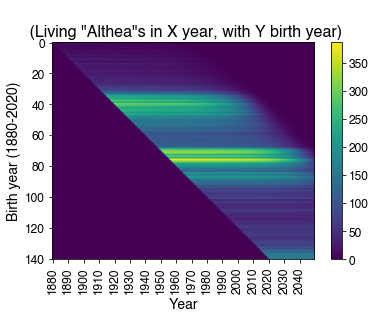

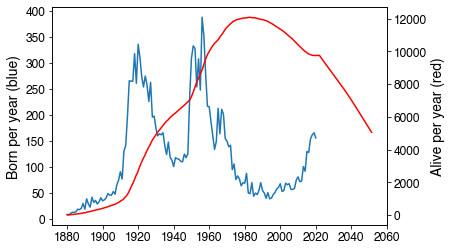

In [23]:
#VISUALIZATION: THIS ONE IS HANDY

if True:
    #Example life of name:

    nameind = namelife_F_name[namelife_F_name=='Althea'].index.values[0]

    fig, ax = plt.subplots(1,1)
    im = plt.imshow(namelife_F_full[nameind,:,:])
    ax.set_title('\n (Living "' + str(namelife_F_name[nameind]) + '"s in X year, with Y birth year)')
    ax.set_xlabel('Year')
    ax.set_xticks(np.arange(0,2050-1880,10))
    ax.set_xticklabels(np.arange(1880,2050,10), rotation=90)

    plt.ylabel('Birth year (1880-2020)')
    plt.colorbar(im)
    plt.show()

    ax = plt.subplot(1,1,1)
    ax.plot(namebirth_F[nameind,:])
    ax2 = ax.twinx()
    ax2.plot(namelife_F_base[nameind,:], color='red')
    # ax.plot([139, 139],[0,4.5e10],color=[0,0,0,0.1])
    #ax.set_xlim([0,138])
    year_x = [0,20,40,60,80,100,120,140,160,180]
    ax.set_xticks(year_x)
    year_tick = (np.array(year_x)+1880).astype('str')
    ax.set_xticklabels(year_tick)
    ax.set_ylabel('Born per year (blue)')
    ax2.set_ylabel('Alive per year (red)')
    plt.show()

In [24]:
namelife_F_full[nameind].shape

(141, 170)

In [25]:
#Takes well under 1 minute now.

#Average life-weighted year-of birth for each name for each year

#DOES NOT CHECK WHETHER ANYONE IS STILL ALIVE IN X YEAR BEFORE 
#DOING MATH, SO EXPECT DIVIDE BY ZERO ERRORS. NaNs are fine for
#showing lack of people alive, but it's not pretty.

#It is possible to do this with matrix multiplication. It would
#take way longer to get organized right than just running it. 

agevec = np.arange(1880,1880+nyears).T

aliveshape = namelife_M_full.shape
namelife_M_yob = np.zeros(namelife_M_base.shape)
namelife_sum = np.sum(namelife_M_full, axis=1)
for rowind in np.arange(0,aliveshape[0]):
    tempsum = namelife_sum[rowind,:]
    namelife_M_yob[rowind,:] = np.matmul(agevec, namelife_M_full[rowind,:,:]) / \
                               namelife_sum[rowind,:]

aliveshape = namelife_F_full.shape
namelife_F_yob = np.zeros(namelife_F_base.shape)
namelife_sum = np.sum(namelife_F_full, axis=1)
for rowind in np.arange(0,aliveshape[0]):
    namelife_F_yob[rowind,:] = np.matmul(agevec, namelife_F_full[rowind,:,:]) / \
                                namelife_sum[rowind,:]

/Users/chmullens/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide
/Users/chmullens/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide


In [26]:
np.save('namelife_F_yob.npy',namelife_F_yob)
np.save('namelife_M_yob.npy',namelife_M_yob)

In [27]:
if showplot:
    plt.plot(np.arange(1880, 2050), namelife_M_base[0,:])
    plt.plot(np.arange(1880, 2050), 
             -1*(namelife_M_yob[0,:] - np.arange(1880,2050)))
    plt.title(namelife_M_name[0])
    plt.legend(['Number alive','Avg age'])
    plt.show()

In [28]:
#General notes:

#This would be a good place in the future to normalize by ESTIMATED
#births in a given birth year. It's reasonable to only use SSA-named
#births, but it's more likely to represent the population well if I
#scale name-set births up by the ratio of estimated total births to
#recorded births.

#How to do that: Calculate estimated births each year 1880+, multiply
#pop of each name from that year by the ratio of estimated births to
#names dataset births. 
#Options for calculating estimated births:
#    -Derive number of births from the census (feasible)
#    -Take the number of people alive of a given age, then scale the 
#     names alive to match (would be inaccurate due to immigration)

In [29]:
#The oldest male and female names in the US:

#OPTIONAL VISUALIZATION

if showplot:
    namrange = 20 #how many to look at
    print('\n\nThese are mostly birth names that appeared in few years, \
    and were held by few people.')

    #Target year: 2020, aka location 1880+140
    nameF_ageind = np.argsort(namelife_F_yob[:,140])
    ax = plt.subplot(1,1,1)
    ax.plot(namelife_F_yob[nameF_ageind,140][0:namrange])
    ax.set_xticks(range(namrange))
    ax.set_xticklabels(namelife_F_name[nameF_ageind][0:namrange], rotation=90)
    ax.set_title('Oldest female birth names')
    ax.set_ylabel('Average year of birth')
    plt.show()

    nameM_ageind = np.argsort(namelife_M_yob[:,140])
    ax = plt.subplot(1,1,1)
    ax.plot(namelife_M_yob[nameM_ageind,140][0:namrange])
    ax.set_xticks(range(namrange))
    ax.set_xticklabels(namelife_M_name[nameM_ageind][0:namrange], rotation=90)
    ax.set_title('Oldest male birth names')
    ax.set_ylabel('Average year of birth')
    plt.show()

In [30]:
#Common names by age:

#OPTIONAL VISUALIZATION

if showplot:
    fig = plt.figure(figsize=[12,10], facecolor='white')
    ax = plt.subplot(2,1,1)
    plt.grid(b=True, axis='x', color='gray')
    ax2 = plt.subplot(2,1,2)
    plt.grid(b=True, axis='x', color='gray')


    n_hold_M = 750000
    n_hold_F = 500000
    numscale = 6000

    #Collect maximum number of holders alive for each name
    namelife_F_max = namelife_F_base.max(1)
    #Collect year index at which that occurred
    namelife_F_max_yr = np.argmax(namelife_F_base, axis=1)
    #Collect the avg. yob at the year index at which that occurred
    namelife_F_max_yob = namelife_F_yob[np.arange(0,len(namelife_F_max)),namelife_F_max_yr]
    #Collect the names for which that max was above the target threshold
    chunk_F = namelife_F_max >= n_hold_F
    #Select the YOB for data that met criteria, then collect year index that sorts it by YOB
    sort_yr_F = np.argsort(namelife_F_yob[chunk_F,2020-1880])
    #Select the number of individuals alive for data that met criteria, sort by above index
    sort_yr_F_alive = namelife_F_base[chunk_F,2020-1880][sort_yr_F]
    #Select the maximum number of individuals alive for data that met criteria, sort by above index
    sort_yr_F_maxalive = namelife_F_max[chunk_F][sort_yr_F]
    #Select the YOB at maximum number of individuals alive for data that met criteria, sort by above index
    sort_yr_F_maxalive_yob = namelife_F_max_yob[chunk_F][sort_yr_F]

    #Repeat above for M
    namelife_M_max = namelife_M_base.max(1)
    namelife_M_max_yr = np.argmax(namelife_M_base, axis=1)
    namelife_M_max_yob = namelife_M_yob[np.arange(0,len(namelife_M_max)),namelife_M_max_yr]
    chunk_M = namelife_M_max >= n_hold_M
    sort_yr_M = np.argsort(namelife_M_yob[chunk_M,2020-1880])
    sort_yr_M_alive = namelife_M_base[chunk_M,2020-1880][sort_yr_M]
    sort_yr_M_maxalive = namelife_M_max[chunk_M][sort_yr_M]
    sort_yr_M_maxalive_yob = namelife_M_max_yob[chunk_M][sort_yr_M]


    xlims = [-2,max([sum(chunk_F), sum(chunk_M)])+1]
    ylims = [1920, 2010]

    n_hold = 300000

    # lin_1 = ax.plot(alivelist_M_yob[chunk_M,2020-1880][sort_yr_M]+1880, color='blue', linewidth=1)
    dot_1a = ax.scatter(x=np.arange(0,sum(chunk_M)),
                        y=sort_yr_M_maxalive_yob,
                        s=sort_yr_M_maxalive/numscale, 
                        color=[[.95,.95,.95]], edgecolor='tab:blue',zorder=5,label='Peak holders')
    dot_1b = ax.scatter(x=np.arange(0,sum(chunk_M)),
                        y=namelife_M_yob[chunk_M,2020-1880][sort_yr_M],
                        s=sort_yr_M_alive/numscale,
                        color='tab:blue', edgecolor='tab:blue',zorder=6,label='Current holders')
    ax.set_xticks(range(sum(chunk_M)))
    ax.set_xticklabels(namelife_M_name[chunk_M].iloc[sort_yr_M], rotation=90)
    ax.set_ylim(ylims)
    ax.set_xlim(xlims)
    # ax.legend()


    # lin_2 = ax2.plot(alivelist_F_yob[chunk_F,2020-1880][sort_yr_F]+1880, color='red', linewidth=1)
    dot_1a = ax2.scatter(x=np.arange(0,sum(chunk_F)),
                        y=sort_yr_F_maxalive_yob,
                        s=sort_yr_F_maxalive/numscale, 
                        color=[[.95,.95,.95]], edgecolor='tab:red',zorder=5,label='Peak holders')
    dot_1b = ax2.scatter(x=np.arange(0,sum(chunk_F)),
                        y=namelife_F_yob[chunk_F,2020-1880][sort_yr_F],
                        s=sort_yr_F_alive/numscale,
                        color='tab:red', edgecolor='tab:red',zorder=6,label='Current holders')
    ax2.set_xticks(range(sum(chunk_F)))
    ax2.set_xticklabels(namelife_F_name[chunk_F].iloc[sort_yr_F], rotation=90)
    ax2.set_ylim(ylims)
    ax2.set_xlim(xlims)

    # plt.grid(axis='y', color=0.9)

    #proxy size labels:
    legendpts = np.array([n_hold, n_hold*3, n_hold*10]).astype('int64')
    scatter_for_legend = ax.scatter(x=[0,0,0], y=[0,0,0], 
                                    s=legendpts/numscale,
                                    c=[[1,1,1,0],[1,1,1,0],[1,1,1,0]]
                                   )
    scatter_for_legend_2 = ax.scatter(x=[0], y=[0],
                                      s=[1.5*legendpts[1]/numscale],
                                      c=['tab:blue'])
    scatter_for_legend_3 = ax.scatter(x=[0], y=[0],
                                      s=[1.5*legendpts[1]/numscale],
                                      c=[[.95,.95,.95]],
                                      edgecolor=['tab:blue'])
    handles, labels = scatter_for_legend.legend_elements(prop="sizes", alpha=0.2)
    handles_2, labels_2 = scatter_for_legend_2.legend_elements(prop="sizes", alpha=1, color=[.25,.5,.85])
    handles_3, labels_3 = scatter_for_legend_3.legend_elements(prop="sizes", alpha=1, color=[.95,.95,.95])
    # legend = ax.legend(handles=handles+[]+handles_2+handles_3,
    #                    labels=['{0:,}'.format(m) for m in legendpts]+[]+['Living', 'Peak'],
    #                    loc="center right",
    #                    handletextpad=3,
    #                    labelspacing=1,
    #                    framealpha=1,
    #                    title="Number of holders"
    #                   )
    legend = ax.legend(handles=handles+[]+handles_2+handles_3,
                       labels=['{0:,}'.format(m) for m in legendpts]+[]+['Living', 'Peak'],
                       loc="center right",
                       handletextpad=3,
                       labelspacing=1,
                       framealpha=1,
                       title="Number of holders"
                      )

    ax.set_title('All US birth names that reached more than {0:,}(M) or {1:,}(F) holders alive'.format(n_hold_M,n_hold_F))
    ax.set_ylabel('Year of birth (M)')
    ax2.set_ylabel('Year of birth (F)')
    # fig.set_ylabel('Average year of birth for holders')
    # ax2.set_ylabel('Average year of birth for holders living in 2020')
    fig.tight_layout()

    plt.show()

In [31]:
#Assign names aliveness ranks by year
aliverank_M_yr = np.full(namelife_M_base.shape, np.nan)
for n in range(aliveshape[2]):
    tempset = namelife_M_base[:,n] != 0
    aliverank_M_yr[tempset,n] = np.argsort(-namelife_M_base[tempset,n])
aliverank_F_yr = np.full(namelife_F_base.shape, np.nan)
for n in range(aliveshape[2]):
    tempset = namelife_F_base[:,n] != 0
    aliverank_F_yr[tempset,n] = np.argsort(-namelife_F_base[tempset,n])

In [32]:
#Future potential comparisons:

#Stacked line plot of all high-count names (i.e. with >10,000 holders),
#with color of the swath for that name varying w/ avg age at the x-axis
#time. Large plot!

#Geographic names (cities, states, rivers?)
#Names and abbreviations (Lawrence and Larry, Christopher and Chris, 
#Robert and Bob/Rob, Richard and Rick/Dick, Harold and Harry, Thomas
#and Tom/Thom, etc.


In [33]:
#Generate namedata for a given range/age/sex, returning only the 
#top-100 subset, rather than the full sorted data.

def get_namedata(year_range,
                 age_range,
                 sex,
                 totalnon,
                 n_names_store=100, 
                 show_scores=False, 
                 justpopular=False,
                ):
    """
    This function calculates the data used for the visualization functions,
    ranking the individual names based on how well they fit the era and how
    many individuals there were (score calculation line bracketed by "#KEY")
    
    MAKE SURE THE 'totalnon' INPUT IS RIGHT! Must be the total person-years
    per name/index for the correct sex! It should throw a mismatched-size 
    error if you give it the wrong one, but better safe than sorry. 
    
    Relies on the "namelife_{F/M}_full" datastructures being in memory.     
    """
    
    
    #We want to look at the 20-30 range for each of 4 years, for example
    #Year targets: n1-1880, n2-1880
    year1 = year_range[0] - 1880
    year2 = year_range[1] - 1880
    yeardiff = year2 - year1

    age1 = age_range[0]
    age2 = age_range[1]
    agediff = age2 - age1

    startinds = year1 - age2 + np.arange(yeardiff)
    
    s = sex
    
    #print('Startinds, agediff, yeardiff, year1')
    #print(startinds, agediff, yeardiff, year1)
    
    if s=='F':
        # #How many person-years were lived in the target:
        # totaltgt = np.sum(namelife_F_full[:, coh1:coh2, year1:year2], axis=(1,2))

        #Mask to only keep people from each year who were in the target
        #EX: for ages 20-30 in years 1990-1995: for each (ind0) name, look
        #at (ind1) birth years 1960-1970, for (ind2) current year 1990.
        #Do that for 1990-1995. 1961-1971 for 1991, etc.

        #For each cohort, we only want to count years that they lived
        #that fell in that age range during that time span. 

        #tgt_mask = np.zeros_like(namelife_F_full, dtype='bool')
        ##For each year in the range,
        #for n in range(yeardiff):
        #    #Set the birth years corresponding to the age range to 1
        #    tgt_mask[:, startinds[n]:startinds[n]+agediff, year1+n] = True
        #totaltgt = np.sum(namelife_F_full * tgt_mask, axis=(1,2))
        
        #MASK WORKS, BUT VERY SLOW. Already have to get indices, just sum!
        totaltgt = 0
        #For each year in the range,
        for n in range(yeardiff):
            #Add the years lived by birth years corresponding to the age range
            totaltgt += np.sum(namelife_F_full[:, startinds[n]:startinds[n]+agediff, year1+n], axis=1)
        
    elif s=='M':
        totaltgt = 0
        #For each year in the range,
        for n in range(yeardiff):
            #Add the years lived by birth years corresponding to the age range
            totaltgt += np.sum(namelife_M_full[:, startinds[n]:startinds[n]+agediff, year1+n], axis=1)
        
    else:
        print('Gender options in social security name data are M or F')
        return None
        
    #Calculate what percent of name's person-years happened in that window
    name_specificity = totaltgt/totalnon
    #Weight by total number with that name in the window
    name_weight = totaltgt
    
    #KEY
    #KEY
    #KEY
    #Calculate score: 
    #OLD, squareroot(number in window) times square(specificity)
    #NEW, square(log10(number in window)) times specificity
    name_score = 10 * (np.log10(name_weight+1))**2 * name_specificity
    #KEY
    #KEY
    #KEY
    
    #Feature explanation: log10 scaling decreases influence of each birth as
    #births rise. Squaring this value decreases influence of numbers under 10,
    #increases weight of numbers over 10, but much less drastically than the
    #original linear scaling. 
    #Scale reference, number births -> effective weight:
    #  1 -> 0, 10 -> 1, 100 -> 4, 10,000 -> 16
    #I also considered 2**np.log10(name_weight+1), which effectively just
    #raises the base weight to log10(2), (about 0.30), but it doesn't damp
    #the low end (1-10 person-year) as effectively.

    
    
    #Grab the average age for all nameholders during the window
    if s=='F':
        #Calculate mean year of the range, then subtract the mean
        #year of birth (per name, :) across the range
        name_ages = (1880*2+year1+year2)/2 - np.mean(namelife_F_yob[:,year1:year2+1], axis=1)
    else:
        name_ages = (1880*2+year1+year2)/2 - np.mean(namelife_M_yob[:,year1:year2+1], axis=1)
    
    #Grab the names themselves
    if s=='F':
        name_outs = namelife_F_name
    else:
        name_outs = namelife_M_name
    
    if justpopular:
        #If you're just looking for most popular:
        nameinds = np.argsort(name_weight)
    else:
        #If you're looking for most representative (DEFAULT):
        nameinds = np.argsort(name_score) #defaults to asc
        
    # #SKIP BELOW CHUNK, CAN REBUILD USING OUTPUT DATA:
    # namedict = {}
    # agedict = {}
    # for n in range(n_names):
    #     dictkey = name_outs[nameinds].iloc[-(n+1)]
    #     if justpopular:
    #         namedict[dictkey] = int(name_weight[nameinds][-(n+1)])
    #     else:
    #         namedict[dictkey] = int(name_score[nameinds][-(n+1)])
    #     agedict[dictkey] = name_ages[nameinds][-(n+1)] 
    
    nameinds_used = nameinds[-n_names_store:]
    namerange_data2 = (name_specificity[nameinds_used],
                       name_weight[nameinds_used],
                       name_score[nameinds_used],
                       name_ages[nameinds_used],
                       name_outs[nameinds_used].values,
                       nameinds_used
                      )
    
    return namerange_data2

In [34]:
# #SANITY-CHECKING MASK-MULTIPLIED-SUM VS INDEX-SUM: 
# #    YES, INDEX-SUM MATCHES

# target_range = [[1895,1896],[0,5],'M']
# totalnon = totalnon
# year_range = target_range[0]
# age_range = target_range[1]
# sex = target_range[2]
# #We want to look at the 20-30 range for each of 4 years, for example
# #Year targets: n1-1880, n2-1880
# year1 = year_range[0] - 1880
# year2 = year_range[1] - 1880
# yeardiff = year2 - year1
# age1 = age_range[0]
# age2 = age_range[1]
# agediff = age2 - age1
# startinds = year1 - age2 + np.arange(yeardiff)
# s = sex

# tgt_mask = np.zeros_like(namelife_M_full, dtype='bool')
# #For each year in the range,
# for n in range(yeardiff):
#    #Set the birth years corresponding to the age range to 1
#    tgt_mask[:, startinds[n]:startinds[n]+agediff, year1+n] = True
# totaltgt1 = np.sum(namelife_M_full * tgt_mask, axis=(1,2))

# #MASK WORKS, BUT VERY SLOW. Already have to get indices, just sum!
# totaltgt2 = 0
# #For each year in the range,
# for n in range(yeardiff):
#     #Add the years lived by birth years corresponding to the age range
#     totaltgt2 += np.sum(namelife_M_full[:, startinds[n]:startinds[n]+agediff, year1+n], axis=1)

# print('Identical checksums, identical at all points:')

# fig, axs = plt.subplots(3,1, figsize=[6,6])
# axs[0].plot(totaltgt1)
# axs[1].plot(totaltgt2)
# axs[2].plot(totaltgt2 - totaltgt1)

In [35]:
#FEATURE ENGINEERING TEST:

# x = np.logspace(0,5,500)
# plt.plot(x, np.log(x))
# plt.show()
# plt.semilogx(x, np.log10(x))
# plt.semilogx(x, np.log10(x)**2)
# plt.show()
# plt.semilogx(x, np.log10(x))
# plt.semilogx(x, np.log10(x)**2)
# plt.xlim([10**-1, 10**2.5])
# plt.ylim([-1,10])
# plt.show()

In [36]:
#USER INPUTS: 

#"Target year"
# -Target year (i.e. 1960)

#"Year range"
# -Year range, +-0, +-2, +-5 (i.e. 1960, 1958-1962, 1955-1965)

#"Target age", LIMITED BASED ON YEAR CHOICE! CAN ONLY DO UP TO ("Target year" - 1880 - agerange/2)
# -Target age (i.e. 20)

#"Age range"
# -Age range, +-2 or +-5 (i.e. 18-22, 15-25)

#"Sex"
# -Sex (M or F)

#Generate all possible ranges of years/ages to check:
print('Year ranges (index/range):')
#Yearsteps: total years around central to compare, i.e. 5 is year-2 through year+2, 1882: 1880-1884
yearsteps = [0,4,10]
yearrange = np.zeros([nyears+1, len(yearsteps), 2], dtype='int32')
for n in range(len(yearsteps)):
    print(n, yearsteps[n])
    yearrange[:-1-yearsteps[n],n,0] = np.arange(1880, 1880+nyears-yearsteps[n])
    yearrange[:-1-yearsteps[n],n,1] = np.arange(1880+yearsteps[n], 1880+nyears)+1
    
#Generate age ranges to check:
print('Age ranges (index/range):')
agesteps = [4,10]
agerange = np.zeros([101-0, len(agesteps), 2], dtype='int32')
for n in range(len(agesteps)):
    print(n, agesteps[n])
    agerange[:-1-agesteps[n],n,0] = np.arange(0, 100-agesteps[n])
    agerange[:-1-agesteps[n],n,1] = np.arange(0+agesteps[n], 100)+1
    
#Given the above values:
#Total comparisons per target year/age pair: 6
#Total target year/age pairs: 100*140
#Total names per set: 100
#Total data points per name: 5
#Total items: ~30mil, compared to ~1bil in namelife_F_full, a
#50-fold decrease in stored values. 
print(np.prod(namelife_F_full.shape))
print(np.prod([6,100,140,100,3]))

Year ranges (index/range):
0 0
1 4
2 10
Age ranges (index/range):
0 4
1 10
1045283760
25200000


In [37]:
agerange

array([[[  0,   5],
        [  0,  11]],

       [[  1,   6],
        [  1,  12]],

       [[  2,   7],
        [  2,  13]],

       [[  3,   8],
        [  3,  14]],

       [[  4,   9],
        [  4,  15]],

       [[  5,  10],
        [  5,  16]],

       [[  6,  11],
        [  6,  17]],

       [[  7,  12],
        [  7,  18]],

       [[  8,  13],
        [  8,  19]],

       [[  9,  14],
        [  9,  20]],

       [[ 10,  15],
        [ 10,  21]],

       [[ 11,  16],
        [ 11,  22]],

       [[ 12,  17],
        [ 12,  23]],

       [[ 13,  18],
        [ 13,  24]],

       [[ 14,  19],
        [ 14,  25]],

       [[ 15,  20],
        [ 15,  26]],

       [[ 16,  21],
        [ 16,  27]],

       [[ 17,  22],
        [ 17,  28]],

       [[ 18,  23],
        [ 18,  29]],

       [[ 19,  24],
        [ 19,  30]],

       [[ 20,  25],
        [ 20,  31]],

       [[ 21,  26],
        [ 21,  32]],

       [[ 22,  27],
        [ 22,  33]],

       [[ 23,  28],
        [ 23, 

In [38]:
# #GRAB SUBSET FOR TESTING:
# yearrange = yearrange[-15:-13]
# agerange = agerange[-25:-23]

In [ ]:
%%time

n_names_store = 140
#140 is the maximum that results in file sizes under 100MB.

#NOTE: Alternate score systems can be partially reconstructed from
#these data, though the top-names limit means you're reshuffling a
#fairly limited set. The storage size starts to be a little iffy
#above storing 500 per set, that size gives 5x ~300mb structures

arraysize = [len(yearrange), len(agerange), len(yearsteps), len(agesteps), n_names_store]
sel_specif = np.zeros(arraysize)
sel_weight = np.zeros(arraysize)
sel_scores = np.zeros(arraysize)
sel_ages = np.zeros(arraysize)
sel_names = np.ndarray(arraysize, dtype='object')
sel_inds = np.zeros(arraysize, dtype='int')

#Only need to run this once, instead of once per function call
totalnon_M = np.sum(namelife_M_full, axis=(1,2))

for t_yr in range(len(yearrange)):
    for t_ag in range(len(agerange)):
        for s_yr in range(len(yearsteps)):
            for s_ag in range(len(agesteps)):
                
                #TEST WHETHER THIS RANGE IS OUTSIDE DATA:
                go_cond = True
                if (yearrange[t_yr, s_yr][0] == 0) or sum(agerange[t_ag, s_ag] == [0,0])==2:
                    go_cond = False
                #year1 - age2 < 0:
                if yearrange[t_yr, s_yr][0] - agerange[t_ag, s_ag][1] - 1880 < 0:
                    go_cond = False
                #Do I even need to watch for high clipping? Probably not!
                #if yearrange[t_yr, s_yr][1] + agerange[t_ag, s_ag][1] > 
                
                #target_range_F = [yearrange[t_yr,s_yr], agerange[t_ag, s_ag], 'F']
                #namerange_data_F = get_namedata(target_range_F)
                
                if go_cond:
                    print(yearrange[t_yr,s_yr], agerange[t_ag, s_ag])
                    target_range_M = [yearrange[t_yr,s_yr], agerange[t_ag, s_ag], 'M']
                    
                    namerange_data_M = get_namedata(target_range_M[0], target_range_M[1],target_range_M[2],
                                                    totalnon_M, n_names_store=n_names_store)
                    
                    sel_specif[t_yr, t_ag, s_yr, s_ag, :] = namerange_data_M[0]
                    sel_weight[t_yr, t_ag, s_yr, s_ag, :] = namerange_data_M[1]
                    sel_scores[t_yr, t_ag, s_yr, s_ag, :] = namerange_data_M[2]
                    sel_ages[t_yr, t_ag, s_yr, s_ag, :] = namerange_data_M[3]
                    sel_names[t_yr, t_ag, s_yr, s_ag, :] = namerange_data_M[4]
                    sel_inds[t_yr, t_ag, s_yr, s_ag, :] = namerange_data_M[5]
                else:
                    print(yearrange[t_yr,s_yr], agerange[t_ag, s_ag], end=' ')
                    print('outside range')
                    
#NOTE: Alternate score systems can be partially reconstructed from
#these data, though the top-X limit means you're reshuffling a
#fairly limited set. The storage size starts to be a little iffy

In [ ]:
sel_specif.shape

In [ ]:
np.save('sel_specif_M{}.npy'.format(n_names_store),sel_specif)
np.save('sel_weight_M{}.npy'.format(n_names_store),sel_weight)
np.save('sel_scores_M{}.npy'.format(n_names_store),sel_scores)
np.save('sel_ages_M{}.npy'.format(n_names_store),sel_ages)
np.save('sel_names_M{}.npy'.format(n_names_store),sel_names)

In [ ]:
%%time

sel_specif = np.zeros([len(yearrange), len(agerange), len(yearsteps), len(agesteps), n_names_store])
sel_weight = np.zeros([len(yearrange), len(agerange), len(yearsteps), len(agesteps), n_names_store])
sel_scores = np.zeros([len(yearrange), len(agerange), len(yearsteps), len(agesteps), n_names_store])
sel_ages = np.zeros([len(yearrange), len(agerange), len(yearsteps), len(agesteps), n_names_store])
sel_names = np.ndarray([len(yearrange), len(agerange), len(yearsteps), len(agesteps), n_names_store], dtype='object')

#Only need to run this once, instead of once per function call
totalnon_F = np.sum(namelife_F_full, axis=(1,2))

for t_yr in range(len(yearrange)):
    for t_ag in range(len(agerange)):
        for s_yr in range(len(yearsteps)):
            for s_ag in range(len(agesteps)):
                
                #TEST WHETHER THIS RANGE IS OUTSIDE DATA:
                go_cond = True
                if (yearrange[t_yr, s_yr][0] == 0) or sum(agerange[t_ag, s_ag] == [0,0])==2:
                    go_cond = False
                #year1 - age2 < 0:
                if yearrange[t_yr, s_yr][0] - agerange[t_ag, s_ag][1] - 1880 < 0:
                    go_cond = False
                #Do I even need to watch for high clipping? Probably not!
                #if yearrange[t_yr, s_yr][1] + agerange[t_ag, s_ag][1] > 
                
                #target_range_F = [yearrange[t_yr,s_yr], agerange[t_ag, s_ag], 'F']
                #namerange_data_F = get_namedata(target_range_F)
                
                if go_cond:
                    print(yearrange[t_yr,s_yr], agerange[t_ag, s_ag])
                    target_range_F = [yearrange[t_yr,s_yr], agerange[t_ag, s_ag], 'F']
                    
                    namerange_data_F = get_namedata(target_range_F[0], target_range_F[1],target_range_F[2],
                                                    totalnon_F, n_names_store=n_names_store)
                    
                    sel_specif[t_yr, t_ag, s_yr, s_ag, :] = namerange_data_F[0]
                    sel_weight[t_yr, t_ag, s_yr, s_ag, :] = namerange_data_F[1]
                    sel_scores[t_yr, t_ag, s_yr, s_ag, :] = namerange_data_F[2]
                    sel_ages[t_yr, t_ag, s_yr, s_ag, :] = namerange_data_F[3]
                    sel_names[t_yr, t_ag, s_yr, s_ag, :] = namerange_data_F[4]
                else:
                    print(yearrange[t_yr,s_yr], agerange[t_ag, s_ag], end=' ')
                    print('outside range')
                    

In [ ]:
np.save('sel_specif_F{}.npy'.format(n_names_store),sel_specif)
np.save('sel_weight_F{}.npy'.format(n_names_store),sel_weight)
np.save('sel_scores_F{}.npy'.format(n_names_store),sel_scores)
np.save('sel_ages_F{}.npy'.format(n_names_store),sel_ages)
np.save('sel_names_F{}.npy'.format(n_names_store),sel_names)

In [ ]:
# #Debug:

# fig, axs = plt.subplots(4,1,figsize=[8,16])
# axs[0].plot(sel_specif[0,0,0,0,:])
# axs[0].set_title('Specificity:')
# axs[1].plot(sel_weight[0,0,0,0,:])
# axs[1].set_title('Weight:')
# axs[2].plot(sel_scores[0,0,0,0,:])
# axs[2].set_title('Score:')
# axs[3].plot(sel_ages[0,0,0,0,:])
# axs[3].set_title('Age:')
# plt.show()

# for n in range(n_names_store):
#     print(n, sel_names[0,0,0,0,n])
#     print(sel_weight[0,0,0,0,n], sel_specif[0,0,0,0,n], sel_scores[0,0,0,0,n])
#     print()

# Begin visualization code

Below is the current visualization code. I am in the progress of optimizing this to work from a derived set of data, rather than calculating the full characteristic values for every name at every call. Currently, it uses a pair of matrices around (25000 | 40000) x 140 x 180 (~25k rows for male names, 40k rows for female names) which is a lot, but it could get by on the set of names/properties for each potential window and potential age. If I constrain the windows for year and age range to either 5 or 10 years and only save the top 100 names, then it's a (135+130) x (135+130) x 100 matrix for M and F each, cutting it down from >1 billion elements to ~15 million. 

From the user perspective, that would look like the user selecting a single year and a single age, then whether to use a window of 5 or 10 years around either.

In [ ]:
#Goal colors: Plotly defaults, #EF553B (red), #636EFA (blue):
#https://www.rapidtables.com/convert/color/rgb-to-hsv.html
#HSV, red: 9deg, 75.3%, 93.7%
#HSV, blue: 236deg, 60.4%, 98.0%

In [ ]:
#Convenience function to plot births for a given name

def showname(name, sex):
    subdf = names_df_trim[(names_df_trim['Name']==name) & (names_df_trim['Sex']==sex)]
    plt.figure(figsize=[14,4])
    plt.bar(subdf['Year'],subdf['Number'])
    plt.xlim([1880,2020])
    plt.title(f'Number of {name} ({sex}) born per year')
    plt.show()

In [ ]:
# #Primary data visualization function: WORD CLOUD

# def display_namecloud(namedict, agedict, target_range):
    
#     #DISPLAY:
#     #TODO: Use viridis_r for individual-name age colormap
    
#     #Make a circle mask
#     cscale = 1000
#     x, y = np.ogrid[:cscale, :cscale]
#     mask = (x - cscale/2) ** 2 + (y - cscale/2) ** 2 > (cscale/2-20) ** 2
#     mask = 255 * mask.astype(int)

#     built_cloud = WordCloud(background_color='white',
#                             repeat=False, 
#                             width=800, 
#                             height=500,
#                             max_font_size=250,
#                             mask=mask)
    
#     wcloud = built_cloud.generate_from_frequencies(namedict)

#     fig, ax = plt.subplots(1,1, figsize=[10,10])
#     ax.axis('off')
#     #plt.imshow(wcloud, interpolation='bilinear')
#     #plt.show()
    
#     if target_range[2]=='F':
#         hueval = 4
#     else:
#         hueval = 236
    
#     #Alternative color pulled from:
#     #https://amueller.github.io/word_cloud/auto_examples/a_new_hope.html
#     #Also adapted from:
#     #https://stackoverflow.com/questions/47143461/python-wordcloud-color-by-term-frequency
    
#     #CONSIDER ALTERNATIVE:
#     # colorsys.rgb_to_hls(200/255,100/255,200/255)
    
#     #[120,360]
#     hue_lim = [100,260] #cyan to magenta, through blue. Mean 240, full blue.
#     sat_lim = [100,0]
#     lit_lim = [80,0]
#     age_lim = [target_range[1][0]*.7,target_range[1][1]*1.3]
#     def hue_scaler(num):
#         #Simple linear transformation converts age from (n1)-5:(n2)+5 range to hsl_lim range
#         tgt_hue = hue_lim[0] + (num - age_lim[0])*(hue_lim[1] - hue_lim[0]) / (age_lim[1] - age_lim[0])
#         return tgt_hue
#     def sat_scaler(num):
#         #Scale from desat at old to colorful at young
#         tgt_sat = sat_lim[0] + (num - age_lim[0])*(sat_lim[1] - sat_lim[0]) / (age_lim[1] - age_lim[0])
#         #Scale saturation from middle (use 100,-100 for ex):
#         #         if tgt_sat < (sat_lim[1] + sat_lim[0])/2:
#         #             tgt_sat = sat_lim[1] - tgt_sat
#         return min([100,max([tgt_sat,0])])
#     def lit_scaler(num):
#         tgt_lit = lit_lim[0] + (num - age_lim[0])*(lit_lim[1] - lit_lim[0]) / (age_lim[1] - age_lim[0])
#         return min([100,max([tgt_lit,0])])
    
#     def age_color_func(agedictionary):
#         def my_tf_color_func_inner(word, font_size, position, orientation, random_state=None, **kwargs):
#             temphue = hue_scaler(agedictionary[word])
#             tempsat = sat_scaler(agedictionary[word])
#             templit = lit_scaler(agedictionary[word])
#             #print(agedictionary[word], tempcolor, tempsat)
#             return f"hsl({hueval}, {tempsat:.0f}%, {templit:.0f}%)"
#         return my_tf_color_func_inner
    
#     plt.imshow(wcloud.recolor(color_func=age_color_func(agedict), random_state=3),
#            interpolation="bilinear")
#     plt.show()

In [ ]:
#Primary data visualization function: SPARK(like) TREND LINES

def display_sparklines(namerange_data, target_range, n_names=20):
    
    #ONLY UNPASSED CALL: namebirth_M/namebirth_F
    
    #Define convenience variables:
    coh1 = target_range[0][0] - target_range[1][1] #Oldest cohort: first year minus oldest
    coh2 = target_range[0][1] - target_range[1][0] #Youngest cohort: last year minus youngest
    maxspecif = namerange_data[0].max() #Greatest name specificity, for scale
    
    #Initialize figure with subplots
    fig = make_subplots(n_names+1, 1, 
                        shared_xaxes=True,
                        specs = [[{}] for n in range(n_names+1)],
                        vertical_spacing = 0,
                       )
    
    #Set variables appropriately based on name sex
    if target_range[2]=='M':
        birthsource = namebirth_M
        linecol = 'blue'
        fillbase = 'rgb({0},{0},255)'
    else:
        birthsource = namebirth_F
        linecol = 'red'
        fillbase = 'rgb(255,{0},{0})'
    
    out_lines = np.zeros()
    for i in np.arange(n_names)+1:
        #Define single-name convenience variables 
        peakval = birthsource[namerange_data[5][-1*i],:].max()
        yearscale = 1000*(target_range[0][1]-target_range[0][0])
        anno_text = '<b>' + namerange_data[4].iloc[-1*i] + '</b>, (age {0:.1f})<br>'.format(namerange_data[3][-1*i]) \
                    + '  Specificity: {0:.2f}<br>'.format(namerange_data[0][-1*i]/maxspecif) \
                    + '  Weight (~how many): {0:.0f}k'.format(namerange_data[1][-1*i]/yearscale)
        
        #Plotly plot generation
        #Add bounding box showing target birth years
        fig.add_trace(go.Scatter(x=[coh1, coh1, coh2, coh2],
                                 y=[0,1.2*peakval,1.2*peakval,0],
                                 fill="toself",
                                 mode='lines',
                                 line={'color':'whitesmoke'}
                                ), i+1, 1)
        #fig.add_trace(go.Scatter(x=[coh1, coh1, coh2, coh2],
        #                         y=[0,1.2*peakval,1.2*peakval,0],
        #                         fill="toself",
        #                         mode='lines',
        #                         line={'color':'gray'}
        #                        ), i+1, 1)
        #Add trace of name birth history
        fig.add_trace(go.Scatter(x=np.arange(1880,2050), 
                                 y=birthsource[namerange_data[5][-1*i],:],
                                 mode='lines', 
                                 line={'color':linecol,
                                       'width':max(5*peakval**0.75/100_000**0.75, 0.5)},
                                 name=namerange_data[4].iloc[-1*i],
                                 fill='tozeroy',
                                 fillcolor=fillbase.format(255 - 255*peakval/100_000),
                                ), i+1, 1)
        #Add text stating specificity/weight specifically
        fig.add_annotation(xref='x{}'.format(i+1), yref='y{}'.format(i+1),
                           x=coh2+40, y=0.52*peakval,
                           text=anno_text,
                           showarrow=False,
                           align='left',
                           xshift=100)
        #Format subplot
        fig.update_xaxes(showgrid=False,
                         ticks='',
                         showticklabels=False,
                         range=[coh1-40, coh2+40],
                         domain=[0,.6],
                         zeroline=False,
                        )
        
    fig.update_yaxes(showgrid=False, ticks='', showticklabels=False)
    fig.add_annotation(xref='x1', yref='y1',
                       x=np.mean([coh1, coh2]), y=0.5*peakval,
                       text='<b>Names for ages {0}-{1} in {2}-{3} ({4}):</b>'
                           .format(target_range[1][0],
                                   target_range[1][1],
                                   target_range[0][0],
                                   target_range[0][1],
                                   target_range[2]
                                  ),
                       showarrow=False,
                       align='left',
                       xshift=100)
    fig.update_layout(template=None, 
                      height=n_names*(100*0.55), 
                      width=500,
                      margin={'t':0,'b':0},
                      showlegend=False,
                     )

    fig.show()

In [ ]:
#Primary data visualization function: GENERATE VALUES AND CALL VIS FUNCTION(S)

def get_era_names(target_range, 
                  n_names=25, 
                  show_scores=False, 
                  justpopular=False, 
                  displayfunc=display_sparklines):

    #This function calculates the numbers used in the visualization function.
    
    #We want to look at the 20-30 range for each of 4 years, for example
    #Year targets: n1-1880, n2-1880
    year1 = target_range[0][0] - 1880
    year2 = target_range[0][1] - 1880
    yeardiff = year2 - year1

    age1 = target_range[1][0]
    age2 = target_range[1][1]
    agediff = age2 - age1

    startinds = year1 - age2 + np.arange(agediff)
    
    s = target_range[2]
    
    if s=='F':
        # #How many person-years were lived in the target:
        # totaltgt = np.sum(namelife_F_full[:, coh1:coh2, year1:year2], axis=(1,2))

        #Mask to only keep people from each year who were in the target
        #EX: for ages 20-30 in years 1990-1995: for each (ind0) name, look
        #at (ind1) birth years 1960-1970, for (ind2) current year 1990.
        #Do that for 1990-1995. 1961-1971 for 1991, etc.
        
        #For each cohort, we only want to count years that they lived
        #that fell in that age range during that time span. 
        
        tgt_mask = np.zeros_like(namelife_F_full, dtype='bool')
        #For each year in the range,
        for n in range(yeardiff):
            #Set the birth years corresponding to the age range to 1
            tgt_mask[:, startinds[n]:startinds[n]+agediff, year1+n] = True
        
        totaltgt = np.sum(namelife_F_full * tgt_mask, axis=(1,2))
        #How many person-years were lived in total:
        totalnon = np.sum(namelife_F_full, axis=(1,2))
        
    elif s=='M':
        tgt_mask = np.zeros_like(namelife_M_full, dtype='bool')
        #For each year in the range,
        for n in range(yeardiff):
            #Set the birth years corresponding to the age range to 1
            tgt_mask[:, startinds[n]:startinds[n]+agediff, year1+n] = True
        totaltgt = np.sum(namelife_M_full * tgt_mask, axis=(1,2))
        #How many person-years were lived in total:
        totalnon = np.sum(namelife_M_full, axis=(1,2))
    else:
        print('Gender options in social security name data are M or F')
        return None
        
    #Calculate what percent of name's person-years happened in that window
    name_specificity = totaltgt/totalnon
    #Weight by total number with that name in the window
    name_weight = totaltgt
    #Calculate score: squareroot(number in window) times square(specificity)
    name_score = 10 * np.sqrt(name_weight) * name_specificity**2
    #Grab the average age for all nameholders during the window
    if s=='F':
        #Calculate mean year of the range, then subtract the mean
        #year of birth (per name, :) across the range
        name_ages = (1880*2+year1+year2)/2 - np.mean(namelife_F_yob[:,year1:year2+1], axis=1)
    else:
        name_ages = (1880*2+year1+year2)/2 - np.mean(namelife_M_yob[:,year1:year2+1], axis=1)
    
    #Grab the names themselves
    if s=='F':
        name_outs = namelife_F_name
    else:
        name_outs = namelife_M_name
    
    if justpopular:
        #If you're just looking for most popular:
        nameinds = np.argsort(name_weight)
    else:
        #If you're looking for most representative (DEFAULT):
        nameinds = np.argsort(name_score) #defaults to asc

    namedict = {}
    agedict = {}
    for n in range(n_names):
        dictkey = name_outs[nameinds].iloc[-(n+1)]
        if justpopular:
            namedict[dictkey] = int(name_weight[nameinds][-(n+1)])
        else:
            namedict[dictkey] = int(name_score[nameinds][-(n+1)])
        agedict[dictkey] = name_ages[nameinds][-(n+1)] 
        
    namerange_data = (name_specificity[nameinds],
                      name_weight[nameinds],
                      name_score[nameinds],
                      name_ages[nameinds],
                      name_outs[nameinds],
                      nameinds
                     )

    #Visualization subfunction: WORDCLOUD    
    display_namecloud(namedict, agedict, target_range)
    out_lines = display_sparklines(namerange_data, target_range, n_names=n_names)
    
    #Visualization subfunction: DEFAULT SPARKLINE
    #displayfunc(namerange_data)

    if show_scores:
        print('Specificity, weight, score, avg. age, name:')
        for item in zip(np.round(name_specificity[nameinds][::-1][:n_names],3),
                 np.round(name_score[nameinds][::-1][:n_names],2),
                 np.round(name_ages[nameinds][::-1][:n_names],2),
                 name_outs[nameinds][::-1][:n_names]):
            print(item)
    
    return namerange_data






# Characteristic names: 

Based on a given era and a given age range, can we find names that feel right? 

We're looking for names that are at least fairly common, so you'd expect to see them, but also names that are *uncommon* outside the target range.

The second visualization is close to deployable, Plotly is simple to get html for.

In [ ]:
target_range = [[1990, 1995], [20,25], 'F'] #years, age, sex

namerange_data = get_era_names(target_range, n_names=15)

In [ ]:
target_range[0][1] - target_range[1][0]

In [ ]:
target_range = [[1990, 1995], [20,25], 'F'] #years, age, sex

year1 = target_range[0][0] - 1880
year2 = target_range[0][1] - 1880
yeardiff = year2 - year1

age1 = target_range[1][0]
age2 = target_range[1][1]
agediff = age2 - age1

startinds = year1 - age2 + np.arange(agediff)
endinds = year2 - age2 + np.arange(agediff)
# coh1 = year1 - target_range[1][1] #Oldest cohort: first year minus oldest
# coh2 = year2 - target_range[1][0] #Youngest cohort: last year minus youngest
# cohdiff = coh2 - coh1

In [ ]:
year1+1880, year2+1880

In [ ]:
year1, year2, age1, age2

In [ ]:
print(startinds + 1880)
startinds

In [ ]:
print(endinds + 1880)
endinds

In [ ]:
plt.imshow(pre_tgt_mask[0,:,:])
plt.xlabel('Year')
plt.ylabel('Birth year')
plt.show()

In [ ]:
fig, ax = plt.subplots(1,1, figsize=[8,5])
im = plt.imshow((namelife_F_full * pre_tgt_mask)[nameind,:,:])
ax.set_title('\n (Living "' + str(namelife_F_name[nameind]) + '"s in X year, with Y birth year)')
ax.set_xlabel('Year')
ax.set_xticks(np.arange(0,2050-1880,10))
ax.set_xticklabels(np.arange(1880,2050,10), rotation=90)

plt.ylabel('Birth year (1880-2019)')
plt.colorbar(im)
plt.show()

In [ ]:
pre_tgt = namelife_F_full[:, coh1:coh2, year1:year2]

pre_tgt.shape

In [ ]:
pre_tgt_mask = np.zeros_like(pre_tgt)

In [ ]:
#People 20-25 in 1990: 
#(specifically, people who turned 20-25 during the year 1990)
years1 = (coh1 - yeardiff) + np.arange(yeardiff)
print('Target year 1990, target ages 20-25')
print('Birth years:')
print('1880-indexed cohorts: ',startinds)
print('Year cohorts: ',startinds + 1880)

In [ ]:
startinds = (coh1 - yeardiff) + np.arange(yeardiff)
startinds + 1880

In [ ]:
endinds = (coh1 ) + np.arange(yeardiff)
endinds + 1880

In [ ]:
#OPTIONAL VISUALIZATION: Specificity vs. number alive. Good for
#eyeballing how the score algorithm balances between the two.

#Could use a tune-up. Size could show number alive, for example.
if showplot:
    ann_num = 10
    plt.figure(figsize=[10,6])
    plt.scatter(namerange_data[0], namerange_data[1], c=namerange_data[2])
    for n in range(-1*ann_num,0):
        plt.annotate(text=namerange_data[4].iloc[n], 
                     xy=(namerange_data[0][n], namerange_data[1][n]),
                     xytext=(2,2),
                     textcoords='offset points',
                     rotation=30
                    )
    plt.xlabel("Specificity: Fraction of name's years that were lived in range")
    plt.ylabel('Weight: Number of name-years lived')
    plt.ylim([-200000, 1.15*max(namerange_data[1])])
    plt.box()
    cbar = plt.colorbar()
    cbar.ax.set_ylabel('Characteristicness Score')
    plt.title('Years: {}, Ages: {}, Sex: {}'.format(target_range[0], target_range[1], target_range[2]))
    plt.show()





# Name clustering and prediction:

In short, based on the properties of the names we know of, predict whether a name will increase or decrease in a given year. Currently on version 1, a simple Ridge. Below are notes on how the clustering will work and future improvements and projects that would improve the function. 


### Notes on name similarity clustering:

**The goal:** Cluster names based on how similarly they are spelled or pronounced. 

Let's start with the spelling, since the pronunciation similarity has additional layers of complexity. 

Let's start with the spelling; I'll be using Levenshtein distance as a starting point, which is a very convenient measure of how similar two words are to one another, also known as the "edit distance". It doesn't take into account the fact that there some letters are more similar to one another than others (i.e. "a" is drastically more like "e" than "q"), but it's a great start, and I can update the distance algorithm as I go. (The more complex letter similarity is probably most appropriately handled in the pronunciation clustering, anyway.)

So! The core tech here is going to be **affinity propagation**. For that, we need similarity measures between each pair of words, which to reiterate will be the Levenshtein distance. 

Minor problem: Using the current set of names, the number of comparisons is big. The **total number of comparisons is O(n²)**, which is not good when you have a set of 100,000 names, so I'm pruning the dataset. I'll be focusing on the most relevant names, i.e. those which met a certain threshold of use. One possible threshold: maximum number of people who have had that name at any time. You can see in the plot below what this ends up looking like. You can also see that the name distribution follows a pretty clear pattern. 

In short, to keep our number of comparisons reasonable, **we'll limit it based on peak holders alive.** We can calculate which clusters additional names would fit in pretty easily, but for the clustering itself, this may be close to the outer limits of what we can practically do with affinity propagation using this precomputed distance.

**PROBABLE FUTURE ADDITION:**  
Pre-group names with IDENTICAL predicted pronunciations, THEN get the top set. That will, for example, catch the literally 40 different ways of spelling "Abigail" under a single umbrella, or the "Brayden/Breighdon" etc. name clan.

## Collecting pronunciations for clustering:

In [ ]:
#PRONUNCIATION:

#Calculate word pronunciation based on the Datamuse API response.
#Works fairly well, though some names such as Abrielle get lumped
#together with Gabrielle in pronunciation, as it assumes it has a
#leading G. 
#
#https://api.datamuse.com/words?sl=mackenzie&md=r
#
#This API call returns both a word's pronunciation and words that
#sound like it.

import string
from ediblepickle import checkpoint

#Generate checkpoint data for each function call, which goes in
#the "name_pronunciation_storage" directory. Note that this will
#run identical names twice, once each for male or female, but the
#Datamuse API does not use this information. Could be optimized, 
#but the load process is very quick. 

@checkpoint(key=string.Template('name_pronunc_{0}_{1}.pkl'), work_dir='name_pronunciation_storage', refresh=False)
def get_name_pronunc(name, sex):
    #Define core API call, which works great with the word itself at the end
    baseapi = 'https://api.datamuse.com/words?md=r&ipa=1&sl='
    #Get page response for api+name.
    
    #V1: Use futuressessions
    #REQUIRES THAT A FUTURESSESSION BE ACTIVE! "session = FuturesSession()"
    resp = session.get(baseapi + name)
    #Pull out just the content
    pagecont = resp.result().content
    pagetext = resp.result().text
    
    #V2: Use a standard request
    #resp = requests.get(baseapi + name)
    #pagecont = resp.content
    #pagetext = resp.text
    
    #Fairly messy way to do this, probably ought to use a class
    sylstart = pagetext.find('numSyllables')
    syl = int(pagetext[sylstart+14])
    arpastart = pagetext.find('pron:')
    arpastop = pagetext.find('"', arpastart)
    arpa = pagetext[arpastart+5:arpastop]
    ipastart = pagetext.find('ipa_pron:')
    ipastop = pagetext.find('"', ipastart)
    ipa = pagetext[ipastart+9:ipastop]
    
    #print(ipa)
    pronunc = []
    pronunc.append(syl)
    pronunc.append(arpa)
    pronunc.append(ipa)
    time.sleep(0.05)

    return pronunc, pagetext

In [ ]:
%%time

redo_pronunc = False
#Should functionize this. Takes about a minute to run through
#the whole thing IF you're loading again, since the name data
#loads from checkpoint. If the data is not checkpointed yet,
#the initial collection takes multiple hours. 

if redo_pronunc:
    session = FuturesSession()
    all_pronunciations_F = {}
    all_pagecont_F = []

    for name in namelife_F_name:
        pronunc, pagecont = get_name_pronunc(name, 'F')
        all_pronunciations_F[name] = pronunc
        all_pagecont_F.append(pagecont)
        
    with open('all_pronunciations_F.pkl', 'wb') as fname:
        pickle.dump(all_pronunciations_F, fname)
        
else:
    with open('all_pronunciations_F.pkl', 'rb') as fname:
        all_pronunciations_F = pickle.load(fname)

if redo_pronunc:
    session = FuturesSession()
    all_pronunciations_M = {}
    all_pagecont_M = []

    for name in namelife_M_name:
        pronunc, pagecont = get_name_pronunc(name, 'M')
        all_pronunciations_M[name] = pronunc
        all_pagecont_M.append(pagecont)
        
    with open('all_pronunciations_M.pkl', 'wb') as fname:
        pickle.dump(all_pronunciations_M, fname)
        
else:
    with open('all_pronunciations_M.pkl', 'rb') as fname:
        all_pronunciations_M = pickle.load(fname)
    

In [ ]:
#OLD CONTENT: (works, but not functionized)

# session = FuturesSession()
# baseapi = 'https://api.datamuse.com/words?md=r&sl='
#
# temptime = time.time()
# all_responses_F = []
# all_pronunciations_F = []
# for name in alivelist_F_name[:1000]:
#     resp = session.get(baseapi + name)
#     pagecont = resp.result().content
#     time.sleep(0.05)
#     all_responses_F.append(pagecont)
#
#     #find the pronunciation tag itself:
#     startpt = pagecont.find(b'tags')
#     endpt = pagecont.find(b']', startpt)
#     all_pronunciations_F.append(pagecont[startpt+8:endpt])
#   
# all_pronunciations_M = []
# for name in alivelist_M_name[:1000]:
#     resp = session.get(baseapi + name)
#     time.sleep(0.05)
#     all_pronunciations_M.append(resp)
#
# print(time.time() - temptime)




In [ ]:
#     #saved earlier, copied here for reference convenience

#     names_df_trim = pd.read_pickle('names_df_trim.pkl')
#     #saved above if refresh
#     namelife_F_full = np.load('namelife_F_full.npy')
#     namelife_F_base = np.load('namelife_F_base.npy')
#     namelife_F_name = pd.read_pickle('namelife_F_name.pkl')
#     namebirth_F = np.load('namebirth_F.npy')
#     namelife_M_full = np.load('namelife_M_full.npy')
#     namelife_M_base = np.load('namelife_M_base.npy')
#     namelife_M_name = pd.read_pickle('namelife_M_name.pkl')
#     namebirth_M = np.load('namebirth_M.npy')

In short, the pronunciations are very reasonable in most cases, though they do look like they sometimes default to a known pronunciation when words are spelled similarly enough (for example, some of the "Abrielle"-style names actually get a "Gabrielle" pronunciation). There's a "Lebronjames" in

## Plan subset of data for clustering:

In [ ]:
#Compare how many names you keep depending on your cutoff threshold
#for whether a name has enough holders (requires hand-tuning, should
#include the code from the earlier )

commons_list_M = []
commons_list_F = []
#Test thresholds of 1-100000, using 20 log steps
testvals = np.logspace(0,5,20)
for n in testvals:
    commons_list_M.append(sum(namelife_M_base.max(1) > n))
    commons_list_F.append(sum(namelife_F_base.max(1) > n))
    
plt.loglog(testvals, commons_list_M, 'b', testvals, commons_list_F, 'r')
plt.xlabel('Minimum people of a given name alive at one time for inclusion')
plt.ylabel('Number of total names')
plt.show()
plt.plot(testvals, commons_list_M, 'b', testvals, commons_list_F, 'r')
plt.xlabel('Minimum people of a given name alive at one time for inclusion')
plt.ylabel('Number of total names')
plt.ylim([0,10000])
plt.show()

#A couple specific test values:
thresh1 = 50
thresh2 = 5000
commons_M_1 = namelife_M_base.max(1) > thresh1
commons_F_1 = namelife_F_base.max(1) > thresh1
commons_M_2 = namelife_M_base.max(1) > thresh2
commons_F_2 = namelife_F_base.max(1) > thresh2

#Total names:
print('note: set is now lightly trimmed coming in, so small thresholds do little')
print('Total male names >{}: '.format(thresh1) + str(sum(commons_M_1)))
print('Total female names >{}: '.format(thresh1) + str(sum(commons_F_1)))
print('Total male names >{}: '.format(thresh2) + str(sum(commons_M_2)))
print('Total female names >{}: '.format(thresh2) + str(sum(commons_F_2)))

In [ ]:
#Name test sets:

thresh=5000

nametest_M_inds = namelife_M_base.max(1) > thresh

nametest_M_name = namelife_M_name[nametest_M_inds]
nametest_M_pron = pd.Series([all_pronunciations_M[tempname][2] for tempname in nametest_M_name])
nametest_M_pronA = pd.Series([all_pronunciations_M[tempname][1] for tempname in nametest_M_name])
nametest_M_num = namelife_M_base[nametest_M_inds].max(1)
nametest_M_birth = namebirth_M[nametest_M_inds,:]

nametest_F_inds = namelife_F_base.max(1) > thresh
nametest_F_name = namelife_F_name[nametest_F_inds]
nametest_F_pron = pd.Series([all_pronunciations_F[tempname][2] for tempname in nametest_F_name])
nametest_F_pronA = pd.Series([all_pronunciations_F[tempname][1] for tempname in nametest_F_name])
nametest_F_num = namelife_F_base[nametest_F_inds].max(1)
nametest_F_birth = namebirth_F[nametest_F_inds,:]

#Raw name test set:
nametest_S_name = np.concatenate([nametest_M_name, nametest_F_name])
nametest_S_pron = np.concatenate([nametest_M_pron, nametest_F_pron])
nametest_S_pronA = np.concatenate([nametest_M_pronA, nametest_F_pronA])

# Name fitting thoughts:

First up, basically time course fitting like this should maybe be done using a RNN (Recurrent Neural Network) in Tensor Flow, it's implemented well with Keras apparently. Second up, how do we get to a large set of predicted outcomes from a similarly-large set of data?

**1. What is the target outcome?**

First option: Predict how popular a given name *should* be in a given year, based on popularity of other names and the name's own popularity in the last, say, five years. Why is this hard? Large number of names. There's a high likelihood of overfitting, among other things. 

Second option: Much simpler, just use the time course correlation between different names over, say, the last 40 years to determine their similarity today. This allows grouping. 

Additional option: Predict name frequency in a given year based on number of each other name currently alive, and their ages (or age structure). This is likely to actually be possible and interesting. 

**2. What to compare?**

Options: Graph distance (Affinity Propagation, Spectral Clustering, Markov Clustering (MCL)?b)

More detailed spelling comparison: Bonus points for contiguous runs of letters that do not change? Shared syllable-equivalents?

Simple option: Semi-manual clustering. Names with identical pronunciation are automatically clustered, along with names with no more than one letter difference. 


**ASSORTED ADDITIONAL FEATURES:**  
-Letters (bag of words style) (include capitals for catching initial letters!)  
-Letter bigrams bag  
-Pronunciation bag  
-Pronunciation bigrams bag  

-Next-letter prediction? I've seen this done, could be interesting. 

-Clustering time-series!
https://www.researchgate.net/publication/4756297_Model-Based_Clustering_of_Multiple_Time_Series.
Looks like it would be a bit of a pain to implement, but potentially really interesting. 

In [ ]:
from sklearn.cluster import AffinityPropagation

#Using the distance module for Levenshtein because sure
import distance

In [ ]:
print(nametest_S_name.shape, nametest_M_name.shape, nametest_F_name.shape)

In [ ]:
%%time

#This is a costly part. Takes about 7 minutes at a threshold of >5000 alive.

#Borrowing from code:
#https://stats.stackexchange.com/questions/123060/clustering-a-long-list-of-strings-words-into-similarity-groups
#https://stackoverflow.com/questions/21511801/text-clustering-with-levenshtein-distances

#pronA takes noticeably more time, since the strings are longer. 

lev_similarity_name = 1-np.array([[distance.nlevenshtein(nameM1,nameM2) for nameM1 in nametest_M_name] for nameM2 in nametest_M_name])
lev_similarity_pron = 1-np.array([[distance.nlevenshtein(nameM1,nameM2) for nameM1 in nametest_M_pron] for nameM2 in nametest_M_pron])
lev_similarity_pronA = 1-np.array([[distance.nlevenshtein(nameM1,nameM2) for nameM1 in nametest_M_pronA] for nameM2 in nametest_M_pronA])

In [ ]:
%%time

#Not very costly. Once the similarity matrices are built, the cluster fitting
#only takes a few seconds.

#Set up a near-default affinity propagation instance
affprop_M_name = AffinityPropagation(affinity='precomputed', preference=0, random_state=None)
affprop_M_pron = AffinityPropagation(affinity='precomputed', preference=0, random_state=None)
# affprop_M_pronA = AffinityPropagation(affinity='precomputed', preference=0) #Basically doesn't converge.

affprop_M_name.fit(lev_similarity_name)
affprop_M_pron.fit(lev_similarity_pron)
# affprop_M_pronA.fit(lev_similarity_pronA)

#The ARPABET pronunciation does not really converge on its own,
#looks like it may not cluster very neatly on its own. 

#However, as an additional perspective on pronunciation, it's 
#probably still useful to add. In practice, the clusters do 
#seem to make more sense when it's included.

#After fiddling with it a little, the most "sensible" clusters seem
#to come from weighting the pronunciations at about .75 apiece, so
#they make up more than half the total but less than double the
#spelling weight. 

affprop_M_triple = AffinityPropagation(affinity='precomputed', preference=0.1, random_state=None)
affprop_M_triple.fit(lev_similarity_name + 0.75*lev_similarity_pron + 0.75*lev_similarity_pronA)

#### Affinity propagation notes:

The IPA pronunciation-difference Levenshtein similarity is not very good. It would probably be better to implement the ARPABET pronunciations, since that model contains useful information about sound similarity based on just the characters present in each sound's codeb. That will take a lot more work, since it'd be effectively two-level Levenshtein, I'd have to think about how to reconcile that. 

One way would be instead of "one-character substitution" you could implement "character difference". For example, the "A" in "Adrian" is "EY1", where the "A" in "Andrew" is "AE1". That would be a Levenshtein distance of 2 (one subtraction to E1, one addition to AE1, or other ways to get there). Okay so that's not necessarily the greatest, since it would give a normalized Levenshtein of 0.66 (2/3 difference) when the sounds are reasonably similar, but it's still better than the complete difference that IPA would give. Character addition/subtraction would still be a binary scale. 

(Tried to find a measure of how "far apart" different vowels are, but the data isn't included in a paper that does what looks like a good job of it: http://www.martijnwieling.nl/files/Interspeech2013-FTetal.pdf)

In [ ]:
tgt_affprop = affprop_M_triple
tgt_namebirth = namebirth_M

print(len(np.unique(tgt_affprop.labels_)))
for cluster_id in np.unique(tgt_affprop.labels_):
    exemplar = nametest_M_name.iloc[tgt_affprop.cluster_centers_indices_[cluster_id]]
    cluster = np.unique(nametest_M_name.iloc[np.nonzero(tgt_affprop.labels_==cluster_id)])
    cluster_str = ", ".join(cluster)
    print(" - *%s:* %s" % (exemplar, cluster_str))
    
#Functionally, some of this is tracking what sounds are popular, which is fine.

#The clusters are more or less sensible. Some names don't fit in very well; may
#want to consider once again trying to hunt down an algorithm that's more willing
#to leave solo clusters, because some of these names just flat don't fit very well
#with any other name. 

In [ ]:
#Example name comparison

testname1 = 'Andrew'
testname2 = 'Adrian'

print('Example name comparison with eye toward comparing sounds later:\n')
print(testname1)
print(all_pronunciations_M[testname1])
print(testname2)
print(all_pronunciations_M[testname2])
print('\nSpelling Lev:')
print(distance.nlevenshtein(testname1,testname2))
print('IPA Lev:')
print(distance.nlevenshtein(all_pronunciations_M[testname1][2], all_pronunciations_M[testname2][2]))
print('ARPABET Lev:')
print(distance.nlevenshtein(all_pronunciations_M[testname1][1], all_pronunciations_M[testname2][1]))

sound1 = all_pronunciations_M[testname1][1].split()[0]
sound2 = all_pronunciations_M[testname2][1].split()[0]
print('ARPABET first sound Lev: ' + sound1 + ' vs ' + sound2)
print(distance.nlevenshtein(sound1, sound2))

In [ ]:
#Generate cluster timecourses:

cluster_courses = np.zeros([len(np.unique(tgt_affprop.labels_)),nametest_M_birth.shape[1]])
for i,cluster_id in enumerate(np.unique(tgt_affprop.labels_)):
    cc = nametest_M_birth[tgt_affprop.labels_==cluster_id,:]
    cluster_courses[i,:] = np.sum(cc, axis=0)
    
#Normalize to year total -> fraction of year's births in X cluster
cc_norm = cluster_courses/np.sum(cluster_courses, axis=0)
#Normalize from fraction of year to standard scale
cc_norm2 = (cc_norm - np.mean(cc_norm, axis=1).reshape(-1,1))/np.std(cc_norm, axis=1).reshape(-1,1)

# plt.plot(cc_norm.T)
# plt.show()

In [ ]:
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.model_selection import train_test_split

#Fit first-10 with visual verification:
name_linmodels = []

#The scores are often terrible, because it's comparing versus
#using the mean of the KNOWN data, but visually inspecting the
#first 30 or so it's actually doing a reasonable job in most
#cases. 
for n in range(30):
    lin_mod = Ridge(alpha=0.01)

    y_examp = nametest_M_birth[n,:].T
    X_examp = np.hstack([cc_norm2.T, np.arange(1880,2020).reshape(-1,1)])

    #Random split:
    #X_train, X_test, y_train, y_test = train_test_split(X_examp, y_examp, test_size=0.25)
    #Year split:
    X_train, X_test, y_train, y_test = X_examp[:-5], X_examp[-5:], y_examp[:-5], y_examp[-5:]

    lin_mod.fit(X_train, y_train)
    
    y_pred = lin_mod.predict(X_test)
    
    print(nametest_M_name.iloc[n])
    print(lin_mod.score(X_test, y_test))
    
    plt.plot(X_train[:,-1], y_train, 'b.')
    plt.plot(X_test[:,-1], y_test, 'b+')
    plt.plot(X_test[:,-1], y_pred, 'rx')
    plt.legend(['Train','Test-actual','Test-pred'])
    plt.show()
    

In [ ]:
%%time

X_examp = np.hstack([cc_norm2.T, np.arange(1880,2020).reshape(-1,1)])

#Re-fit using entire set prior to the last 5 years. Repeat this multiple
#times using random sets of the data each time. 

n_refits = 20
name_linmodels = []
# name_linmodels = np.zeros([nametest_M_birth.shape[0], X_examp.shape[1], n_refits])
name_linmodels_dic = {}
test_scores = []

for n in range(len(nametest_M_name)):
    y_examp = nametest_M_birth[n,:].T

    lin_mod = RidgeCV(cv=n_refits, alphas=[.1])

    #Primitive bootstrap: Fit on partial data repeatedly, then average. 
    #Year split:
    X_train, X_test, y_train, y_test = train_test_split(X_examp[:-5], y_examp[:-5], test_size=0.1)
    lin_mod.fit(X_train, y_train)

    name_linmodels.append(lin_mod)
    #name_linmodels[m, :, n] = lin_mod.coef_

    test_score = lin_mod.score(X_examp[-5:], y_examp[-5:])
    test_scores.append(test_score)
    print('{0}: train {1:.3f}, test {2:.3f}, val {3:.3f} ({4})'.format(nametest_M_name.iloc[n],
                                                                       lin_mod.score(X_train, y_train),
                                                                       lin_mod.score(X_test, y_test),
                                                                       test_score,
                                                                       n
                                                                      ))
    y_pred_st = lin_mod.predict(X_test)
    y_pred_fu = lin_mod.predict(X_examp[-5:])
    if n%20==0:
        plt.plot(X_train[:,-1], y_train, 'b.')
        plt.plot(X_test[:,-1], y_test, 'b+')
        plt.plot(X_test[:,-1], y_pred_st, 'rx')
        plt.plot(X_examp[-5:,-1], y_examp[-5:], 'c+')
        plt.plot(X_examp[-5:,-1], y_pred_fu[-5:], 'mx')
        plt.legend(['Train','Test-actual','Test-pred','Val.-actual','Val.-pred'])
        plt.show()
    name_linmodels_dic[nametest_M_name.iloc[n]] = lin_mod

As you can see in the interspersed test plots, while the scores are very poor, that's because the scoring compares them against the *known* mean value of the last five years. They're actually reasonable predictions given the past history of the name in most cases! Even hitting a score of zero (performing as well as the actual mean of the last five years) is quite good. There are a few notable problems, though. For example, the estimates are often overly-optimistic for names that are currently in a long-term low. It really thought Bert and Cletus were going to come back, for example. Similarly, it sometimes heads significantly negative, which is an obvious problem. 

In [ ]:
len(name_linmodels)

## Name trend detection preliminary conclusion:

With careful variable preprocessing, a simple linear model does a surprisingly good job of tracking name trends without drastic overfitting. I'd need to extend this significantly to allow next-year prediction (i.e. generating projected name-cluster data), but it's a clear sign that we can reasonably track some trends for relatively popular names. To use the prior model for predictions, we'd have to generate synthetic cluster-trend data, which is feasible. For example, let's plug what we have into a time-series model like ARIMA, which uses the time course of the data to project its future trajectory. This is like to do reasonably well for near-future projection, and we can use that projection to generate the synthetic cluster trends necessary for the linear model to predict. Of course, we could also use the ARIMA directly on each name, but that would take hours for the full set of names compared to seconds for the linear model, and would also discard the information we can calculate about how names trend together. 

(Aside: This might actually be a pretty good spot for a multidimensional Kalman filter, which would use information from each timecourse variable quite nicely. I've been waiting for an excuse to get one of those going, might finally be the time!)  
(Also, there are 0 babies named Arima in the names database, which is honestly a little surprising.)

## ARIMA name timecourse projection:


In [ ]:
len(names_df_trim[names_df_trim['Name'] == 'Arima'])

In [ ]:
import pmdarima as pm
from pmdarima.model_selection import train_test_split

#Handy reference for transforms:
#https://alkaline-ml.com/pmdarima/usecases/sun-spots.html

In [ ]:
%%time

#Testing this on most recent 5 years, so all but last 5 in training set
tsize = 135

num_clust = cc_norm2.shape[0]

arima_mods = []
for n in range(num_clust):
    y = cc_norm2[n,:]
    y_train, y_test = train_test_split(y, train_size=tsize)

    arima_mod = pm.auto_arima(y_train)

    y_pred = arima_mod.predict(y_test.shape[0])  # predict N steps into the future

    ## Visualize the forecasts (blue=train, green=forecasts)
    #x = np.arange(y.shape[0])
    #plt.plot(x[:tsize], y_train, c='blue')
    #plt.plot(x[tsize:], y[tsize:], 'b--')
    #plt.plot(x[tsize:], y_pred, c='green')
    #plt.show()
    
    arima_mods.append(arima_mod)

In [ ]:
#Build the predicted-cluster-trend matrix

y_pred_arima = np.zeros([num_clust, 5])
for n in range(num_clust):
    y_pred_arima[n,:] = arima_mods[n].predict(5)

### Actual name trend predictions:

In [ ]:
%%time

#STEP 1: REDO THE ARIMAS WITH ALL YEARS

tsize = 140

num_clust = cc_norm2.shape[0]

arima_mods = []
for n in range(num_clust):
    y = cc_norm2[n,:]
    #y_train, y_test = train_test_split(y, train_size=tsize)
    y_train = y

    arima_mod = pm.auto_arima(y_train)

    y_pred = arima_mod.predict(5)  # predict N steps into the future

    ## Visualize the forecasts (blue=train, green=forecasts)
    #x = np.arange(y.shape[0])
    #plt.plot(x[:tsize], y_train, c='blue')
    #plt.plot(x[tsize:], y[tsize:], 'b--')
    #plt.plot(x[tsize:], y_pred, c='green')
    #plt.show()
    
    arima_mods.append(arima_mod)

In [ ]:
y_pred_arima.shape

In [ ]:
#Build the predicted-cluster-trend matrix

y_pred_arima = np.zeros([num_clust, 5])
for n in range(num_clust):
    y_pred_arima[n,:] = arima_mods[n].predict(5)

#Add the pre-predicted value to the stack to convert the 5
#predicted values to a change (6 vals -> 5 differences)
baseval = cc_norm2[:,-1]
y_pred_arima = np.hstack([baseval.reshape(-1,1),y_pred_arima])
#Calculate the X-predicted in the difference format:
X_pred_arima = np.hstack([np.diff(y_pred_arima).T, np.arange(2020,2025).reshape(-1,1)])

In [ ]:
X_pred_arima.shape

In [ ]:
X_examp.shape

In [ ]:
%%time

#STEP 2: Redo the linear fits to include the complete dataset.

#1. Convert to CHANGE by year (solves most of the negatives problems)
temp_delta = np.diff(cc_norm2) #yes, correct axis (1) is default
temp_bdelta = np.diff(nametest_M_birth) #^same

#2. Start in 1881, since that's the first year we can do diff for
X_examp = np.hstack([temp_delta.T, np.arange(1881,2020).reshape(-1,1)])

n_refits = 20
name_linmodels = []
name_linmodels_dic = {}
test_scores = []

for n in range(len(nametest_M_name)):
    y_examp = temp_bdelta[n,:].T
    
    lin_mod = RidgeCV(cv=n_refits, alphas=[.1])
    
    #With this few data points, I'm throwing the whole thing in for now.
    #The CV is using a subset each time already.
    
    #X_train, X_test, y_train, y_test = train_test_split(X_examp, y_examp, test_size=0.1)
    X_train, y_train = X_examp, y_examp
    lin_mod.fit(X_train, y_train)

    name_linmodels.append(lin_mod)
    
    print('{0}: train {1:.3f} ({2})'.format(nametest_M_name.iloc[n],lin_mod.score(X_train, y_train), n))
    y_pred_fu = lin_mod.predict(X_pred_arima)
    if n%20==0:
        plt.plot(X_train[:,-1], y_train, 'b.')
        #plt.plot(X_test[:,-1], y_test, 'b+')
        #plt.plot(X_test[:,-1], y_pred_st, 'rx')
        #plt.plot(X_examp[-5:,-1], y_examp[-5:], 'c+')
        #plt.plot(X_examp[-5:,-1], y_pred_fu[-5:], 'mx')
        plt.plot(np.arange(2020,2025), y_pred_fu)
        plt.legend(['Train','Test-actual','Test-pred','Val.-actual','Val.-pred'])
        plt.show()
    name_linmodels_dic[nametest_M_name.iloc[n]] = lin_mod

In [ ]:
#STEP 3: MAKE NAME PROJECTIONS

n_names = len(nametest_M_name)

name_futures = np.zeros([n_names,5])
for n in range(n_names):
    name_futures[n,:] = name_linmodels[n].predict(X_pred_arima)
    

In [ ]:
#Testrun: First 30 names

for n in range(30):
    plt.plot(np.arange(1880,2020), nametest_M_birth[n,:])
    plt.plot(np.arange(2020,2025), nametest_M_birth[n,-1] + name_futures[n,:] - name_futures[n,0], 'b+')
    plt.title(nametest_M_name.iloc[n])
    plt.show()

Modifications: I should do a log transform on the data early on, to convert it closer to a normal-distribution range of values, which would respond more appropriately to linear fitting. That's going near the top of the list, it will have a real effect on how well most models can characterize the data. 

Overly-optimistic predictions for near-dead names could be handled better at the individual-name level with ARIMA, despite the drastically slower processing. Similarly, ARIMA would likely also do fairly well avoiding negatives, since the graph tends to flatten as it nears zero. That's largely handled with the transition to yearly change, though. A hybrid model using both could probably do pretty well, but it would be difficult to reasonably fit given the data, and at that point you might want to head into more complex territory like RNN. 

Anyway, predicting names is inherently a difficult problem. We don't have reliable time components to the signal that we can account for, or a massive pile of datapoints. There are generation-related timing elements, but those are close to random, and how long trends persist may be changing. 

Pulling in data on name popularity on a state-by-state basis would help quite a bit, bumping our dataset from about 140 datapoints to about 5000 (some state reporting didn't get going until later if I'm recalling right, so it's not quite 140 x 51). It certainly wouldn't solve the problem by itself! State name trends are strongly correlated with national trends, especially as media increasingly moves away from the local level. State data could significantly help, but it will be necessary to use models that account for correlation between variables. 

Future directions for name trend prediction, in summary:
- More in-depth data transformation prior to analysis/modeling (log or Box-Cox transform built into `pmdarima`, for example)
- Consider multivariate autoregression (i.e. VAR) to model multivariate time series data more effectively (not likely to make the ARIMA fitting feasible for individual names without a days-long run)  
- Consider reweighting recent years. Names with a strong recent increase are at a disadvantage in threshold, despite strong likelihood of continuing future presence. Could weigh name prevalence more highly in the last 3-5 years, for example, both to avoid cutting them off at the threshold stage and to increase the attention the model pays to recent trends? Something to consider.
- Add state data to improve models (at minimum should reduce year-level noise, important now that it's predicting based on yearly change)
- Toss this into an actual user interface/prediction engine. 

In [ ]:
#Assorted fun side comparisons:

#Names in '50 ways to leave your lover' by Paul Simon:
#https://www.azlyrics.com/lyrics/paulsimon/50waystoleaveyourlover.html
#Jack, Stan, Roy, Gus, Lee

#Names in 'Mambo No. 5' by Lou Bega:
#https://www.azlyrics.com/lyrics/loubega/mambono5.html
#Angela, Pamela, Sandra, Rita, Monica, Erica, Rita (again), Tina, Sandra, Mary, Jessica

#Names in '88 lines about 44 wome' by The Nails:
#https://genius.com/The-nails-88-lines-about-44-women-lyrics
#Deborah, Carla, Mary, Susan, Reno, Cathy, Vicki, Kamela, Xylla, Joan, Sherry, Kathleen,
#Seattle, Karen, Jeannie, Mary Ellen, Gloria, Mimi, Marilyn, Julie, Rhonda, Patty, Linda, 
#Katherine, Pauline, Jean-Marie, Gina, Jackie, Sarah, Janet, Tanya, Brenda, Rowena, Dee Dee, 
#Debbie Ray, Nina, Bobbi, Eloise, Terri, Ronnie, Jezebel, Dinah, Judy, Amaranta

#State names:
#(self-evident)

#City names: 
#US cities by population (>100,000):
#https://en.wikipedia.org/wiki/List_of_United_States_cities_by_population

#Worldwide cities (>5,000,000):
#https://en.wikipedia.org/wiki/List_of_largest_cities

#Urban vs. rural states:
#https://fivethirtyeight.com/features/how-urban-or-rural-is-your-state-and-what-does-that-mean-for-the-2020-election/
#(Loosely, how many people are within 5 miles of a given census tract)

#Check trendiness: It looks in general like the time course for F
#names may be shorter than the time course for M names. Is that
#true, and if so has it been becoming less true since 2000?

#Could look at that by taking 10-year chunks (looks like about the
#right length to capture a rising or falling trend) and seeing which
#names correlate together for each chunk? Automatic grouping based
#on "trendiness" would be pretty cool. 

#Extend data: I could also cross-correlate names with Google ngrams 
#results for that name, that would be a nice comparison. Excellent
#proxy for whether a name is culturally established!

#Extend data: Cross-correlate artists who made the Billboard top 10
#using their names (i.e. Alanis). Only include cases where the name
#is in both, so simple inner join would be ideal. 


In [ ]:
plt.su